# 0. Melakukan Import Dataset dan Library

In [38]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score,confusion_matrix,make_scorer, accuracy_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from collections import Counter
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
machine_area = pd.read_csv("C:/Users/andre/Desktop/Andrew/ANAVADataVers/penyisihan-data-vers-anava-19/Machine-Area.csv")
machine_list = pd.read_csv("C:/Users/andre/Desktop/Andrew/ANAVADataVers/penyisihan-data-vers-anava-19/Machine-List.csv")
area_list = pd.read_csv("C:/Users/andre/Desktop/Andrew/ANAVADataVers/penyisihan-data-vers-anava-19/Area-List.csv")

In [3]:
train = pd.read_csv("C:/Users/andre/Desktop/Andrew/ANAVADataVers/penyisihan-data-vers-anava-19/train.csv")

# 1. Pra-pemroresan Data (Data Pre-Processing)

In [4]:
train = train.dropna(ignore_index=True)

In [5]:
train.Status.value_counts()

Status
Breakdown    117897
Normal        34183
Warning       10998
Name: count, dtype: int64

In [6]:
def pbackupEncoder(value):
    if value =="Yes":
        return 1
    return 0
    
def priorityEncoder(value):
    if value =="High":
        return 2
    elif value =="Medium":
        return 1
    else:
        return 0

def statusEncoder(value):
    if value =="Breakdown":
        return 2
    elif value =="Warning":
        return 1
    else:
        return 0

def wranglingEDA(df):
    numeric_cols = df.select_dtypes(include=['float']).columns
    z_scores = np.abs(stats.zscore(df[numeric_cols]))
    df = df[(z_scores < 3).all(axis=1)] 
    
    df= df.rename(columns={"Machine":"ID_Mesin"})
    df = df.merge(machine_list, on=['ID_Mesin'], how='inner')
    df = df.merge(area_list, on=['ID_Area'], how='inner')

    df = df.drop(columns=['ID_Transaction','ID_Area','ID_Mesin'])
    
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    delta =  datetime(2025,1,10)- df["timestamp"] 
    df["days"] = delta.dt.days
    df["weeks"] = delta.dt.days//7
    df["months"] = delta.dt.days//30

    df = df.drop(columns="timestamp")
    return df

def wranglingPred(df):
    df["Status1"]= df['Status']=="Breakdown"

    
    df = pd.concat([df, pd.get_dummies(df["Area"], drop_first=True,dtype=int)],axis=1)
    df = pd.concat([df, pd.get_dummies(df["Country Machine"], drop_first=True,dtype=int)],axis=1)
    df = pd.concat([df, pd.get_dummies(df["Mesin"], drop_first=True,dtype=int)],axis=1) 

    df["Power_Backup"] = df["Power_Backup"].apply(pbackupEncoder)
    df["Priority"] = df["Priority"].apply(priorityEncoder)
    df["Status"] = df["Status"].apply(statusEncoder)

    df = df.drop(columns=["Area","Country Machine","Breakdown Category","Mesin"]) 
    
    return df

In [7]:
df_cleanedEDA = wranglingEDA(train)
df_cleanedPred = wranglingPred(df_cleanedEDA)

In [8]:
df_cleanedEDA.to_csv("df_cleanedEDA.csv",index=False)
df_cleanedPred.to_csv("df_cleanedPred.csv",index=False)

In [9]:
df_cleanedEDA = pd.read_csv("C:/Users/andre/Desktop/Andrew/ANAVADataVers/df_cleanedEDA.csv")
df_cleanedPred = pd.read_csv("C:/Users/andre/Desktop/Andrew/ANAVADataVers/df_cleanedPred.csv")

In [10]:
df_cleanedPred.head()

,temperature_10H_max (°C),temperature_10H_min (°C),temperature-1,temperature-2,temperature-3,apparent_temperature_max,apparent_temperature_min,humidity,Voltage-L,Voltage-R,...,Stuffer Linker 4,Stuffer Linker 5,Stuffer Linker 6,Vacuum Filler,Vacuum Filler-2,Vacuum Filler-3,Vacuum Filler-4,Vacuum Filler-5,Vacuum Tumbler,Wolfking
0,-249.296704,-62.495348,258.380611,19.007804,0.191205,21.468964,-13.393585,40.992421,418.939587,267.236932,...,1,0,0,0,0,0,0,0,0,0
1,551.873540,17.727419,183.334490,16.854997,407.579957,4.535853,-13.661286,27.689588,401.441726,294.617057,...,0,0,0,0,0,0,0,0,0,0
2,416.077475,16.241888,259.830939,33.583118,97.311871,14.294229,-39.108293,30.776412,429.162695,320.527992,...,0,0,0,0,0,0,0,0,0,0
3,536.366064,5.244099,354.307612,11.281673,16.261426,31.183694,-45.909934,38.043534,407.637573,301.109418,...,0,0,0,0,0,0,0,0,0,0
4,736.050764,18.090620,413.068014,46.832235,85.176954,15.512564,-16.462383,30.275704,441.868594,298.297443,...,0,0,0,0,0,0,0,0,0,0


In [153]:
df_cleanedPred.iloc[:5,80:96]

,Risco-TR600,Risco-TR700,Risco-TR800,Stuffer Linker 1,Stuffer Linker 2,Stuffer Linker 3,Stuffer Linker 4,Stuffer Linker 5,Stuffer Linker 6,Vacuum Filler,Vacuum Filler-2,Vacuum Filler-3,Vacuum Filler-4,Vacuum Filler-5,Vacuum Tumbler,Wolfking
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 2. Explorasi Analisis Data

In [12]:
df_cleanedEDA.describe(include="all")

,temperature_10H_max (°C),temperature_10H_min (°C),temperature-1,temperature-2,temperature-3,apparent_temperature_max,apparent_temperature_min,humidity,Voltage-L,Voltage-R,...,Status,Breakdown Category,Mesin,Country Machine,Area,Priority,days,weeks,months,Status1
count,133703.000000,133703.000000,133703.000000,133703.000000,133703.000000,133703.000000,133703.000000,133703.000000,133703.000000,133703.000000,...,133703,133703,133703,133703,133703,133703,133703.000000,133703.000000,133703.000000,133703
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3,44,5,22,3,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Breakdown,Shutdown,Formax,CN,JGJ,Low,NaN,NaN,NaN,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,96719,44884,3727,33417,7803,50885,NaN,NaN,NaN,96719
mean,684.858371,-14.176383,296.046655,28.327196,143.199543,28.407149,-28.381971,37.753625,429.672211,287.947678,...,NaN,NaN,NaN,NaN,NaN,NaN,374.812465,53.113991,12.009252,NaN
std,353.506250,66.058482,115.943062,15.687927,181.127327,15.679908,15.657071,7.630494,10.209004,19.647372,...,NaN,NaN,NaN,NaN,NaN,NaN,211.248672,30.180357,7.051053,NaN
min,-1259.392376,-285.688673,16.518964,0.132182,0.000189,0.012649,-76.437730,22.432530,396.950366,253.720988,...,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,1.000000,0.000000,NaN
25%,474.672012,1.512306,210.058731,16.009633,30.032261,16.105883,-38.710648,31.672948,423.297694,272.149713,...,NaN,NaN,NaN,NaN,NaN,NaN,192.000000,27.000000,6.000000,NaN
50%,602.947525,12.976147,282.032671,26.334361,78.700597,26.410316,-26.349436,36.348716,431.609765,284.195501,...,NaN,NaN,NaN,NaN,NaN,NaN,375.000000,53.000000,12.000000,NaN
75%,826.837317,19.729531,368.395435,38.741708,180.303429,38.845174,-16.090835,42.521629,437.849858,300.176663,...,NaN,NaN,NaN,NaN,NaN,NaN,558.000000,79.000000,18.000000,NaN


In [13]:
df_cleanedEDA.columns

Index(['temperature_10H_max (°C)', 'temperature_10H_min (°C)', 'temperature-1',
       'temperature-2', 'temperature-3', 'apparent_temperature_max',
       'apparent_temperature_min', 'humidity', 'Voltage-L', 'Voltage-R',
       'Voltage-M', 'Current-M', 'Current-R', 'Current-T', 'RPM', 'RPM-1',
       'RPM-2', 'RPM-3', 'Vibration-1', 'Vibration-2', 'Power', 'Power_Backup',
       'Status', 'Breakdown Category', 'Mesin', 'Country Machine', 'Area',
       'Priority', 'days', 'weeks', 'months', 'Status1'],
      dtype='object')

## Visualisasi Satu Variabel

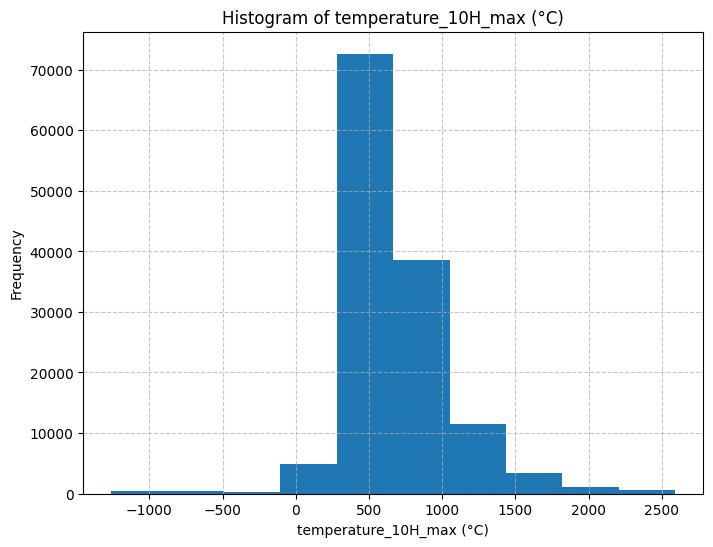

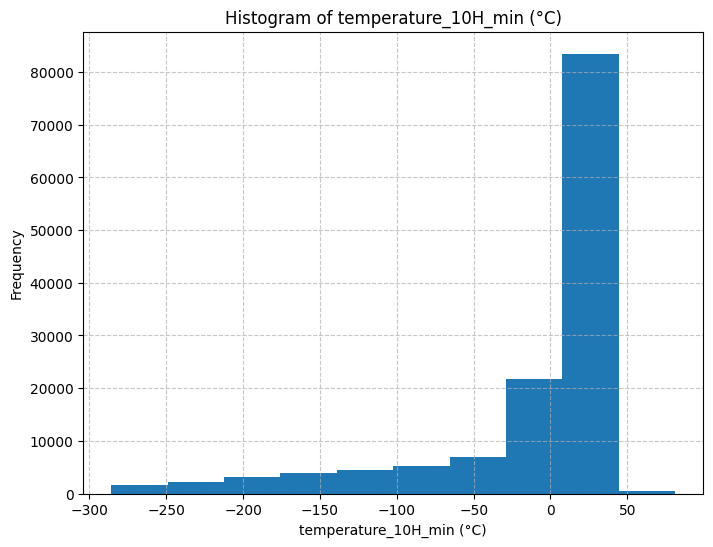

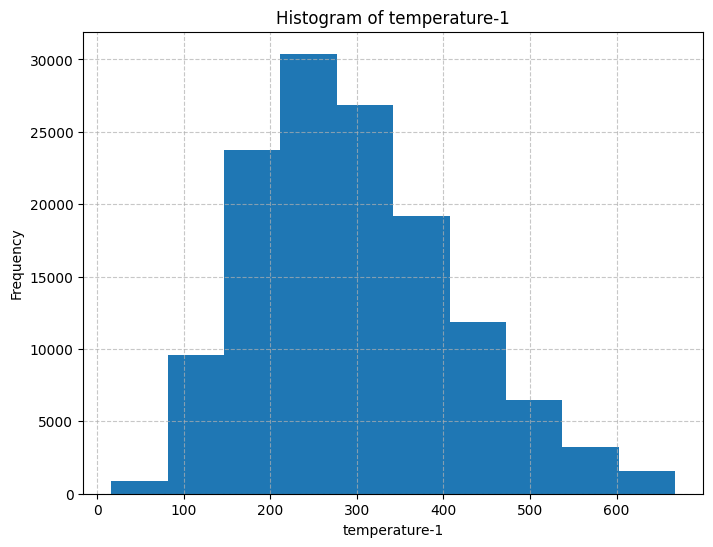

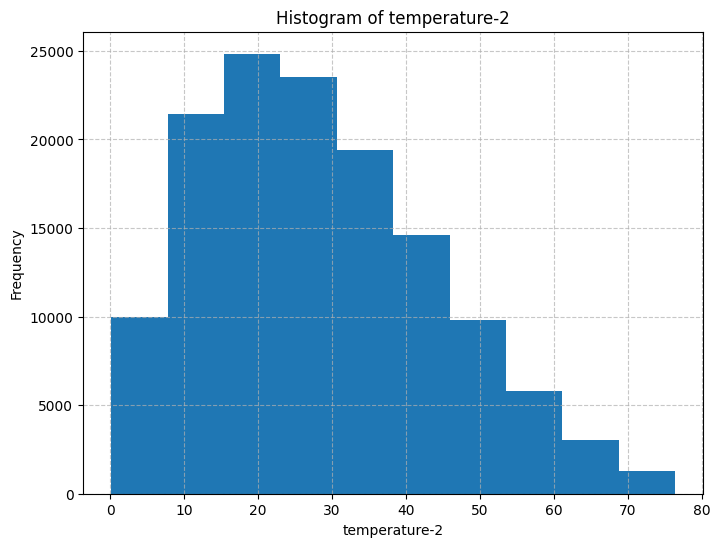

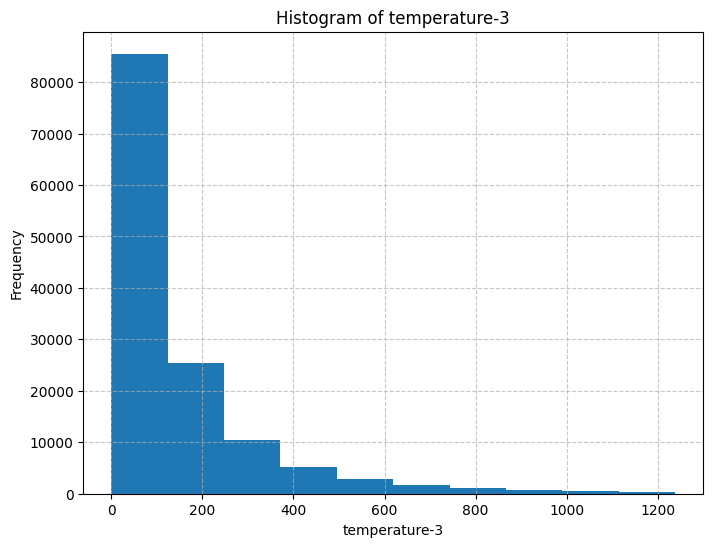

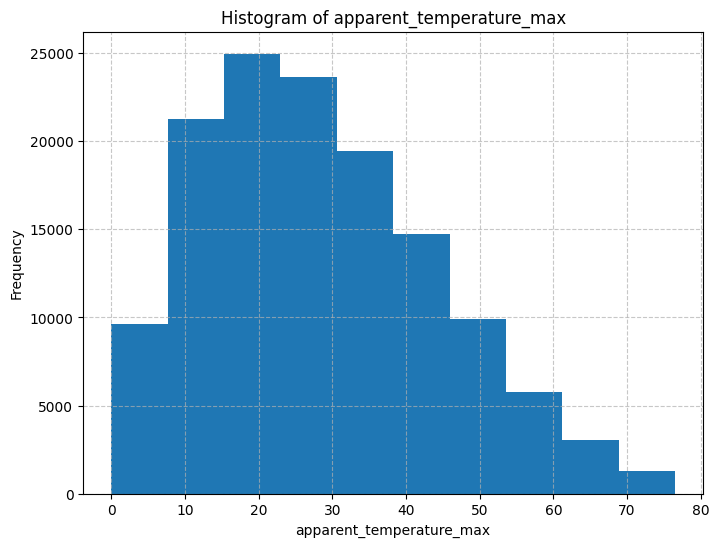

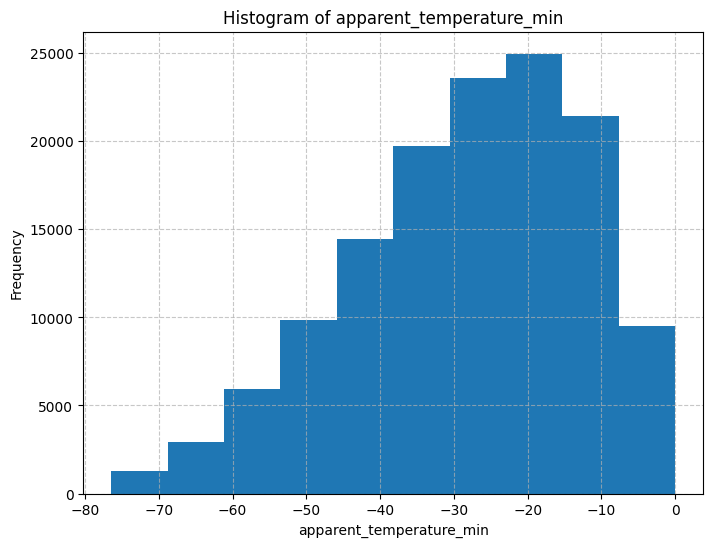

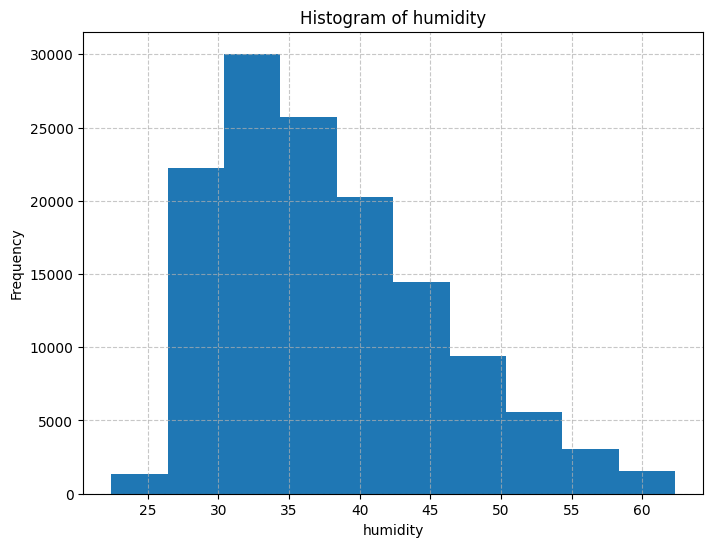

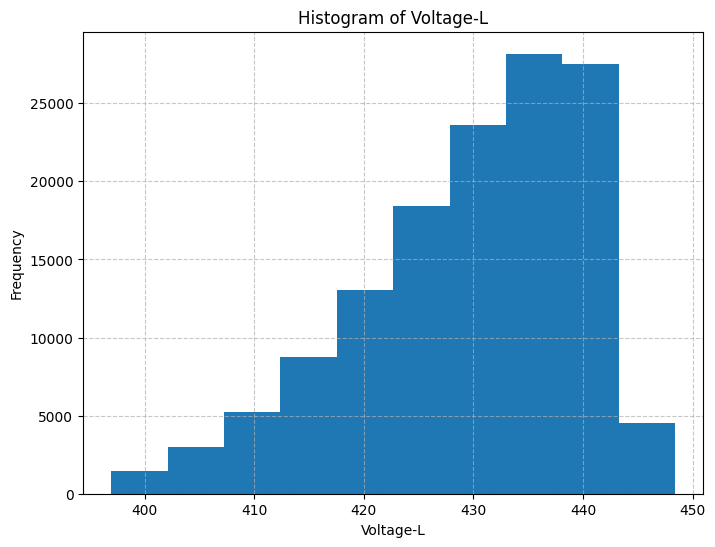

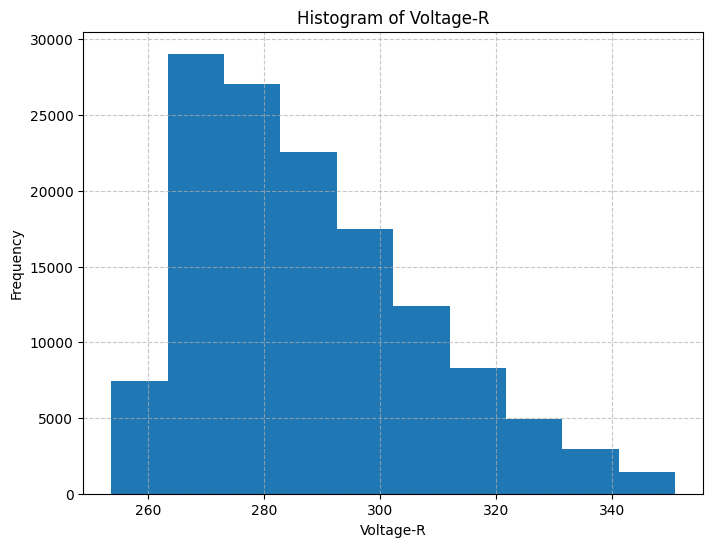

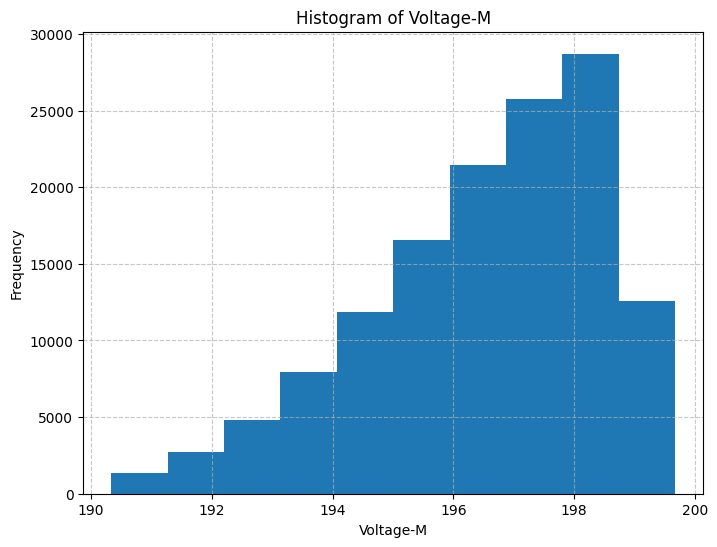

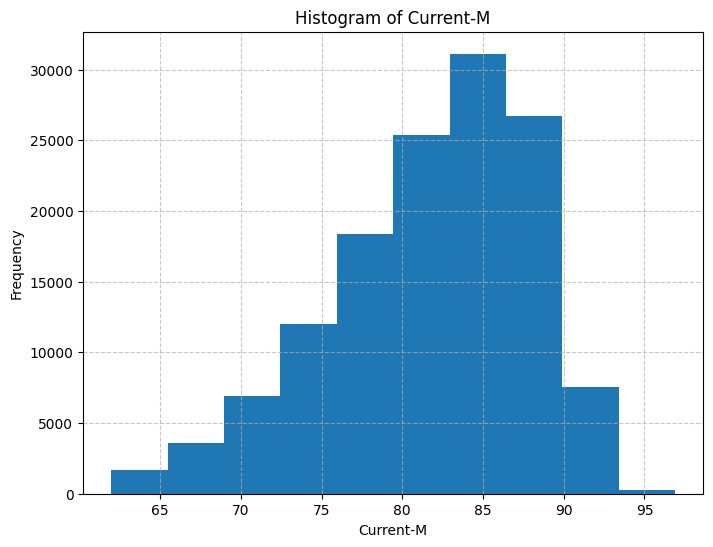

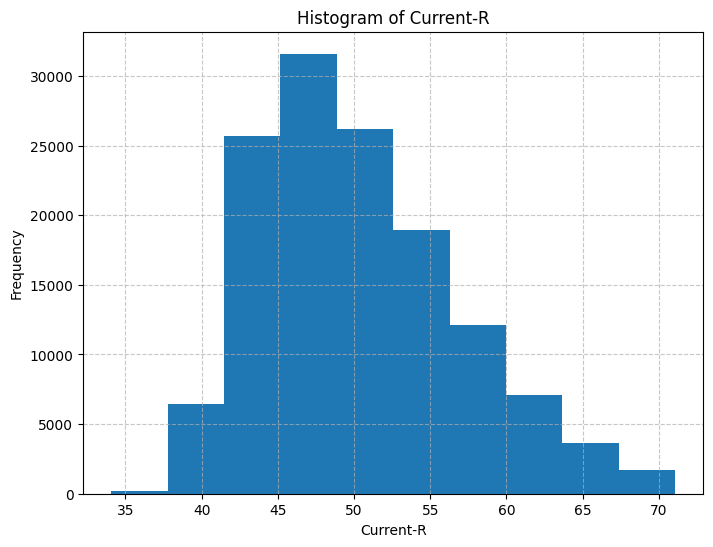

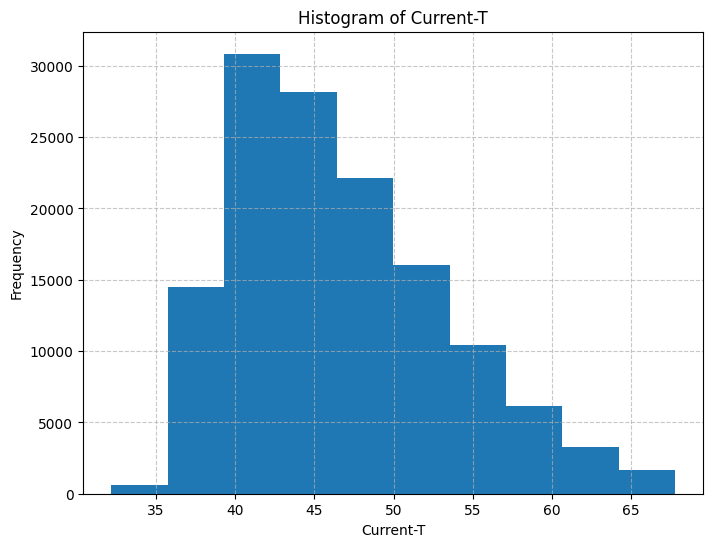

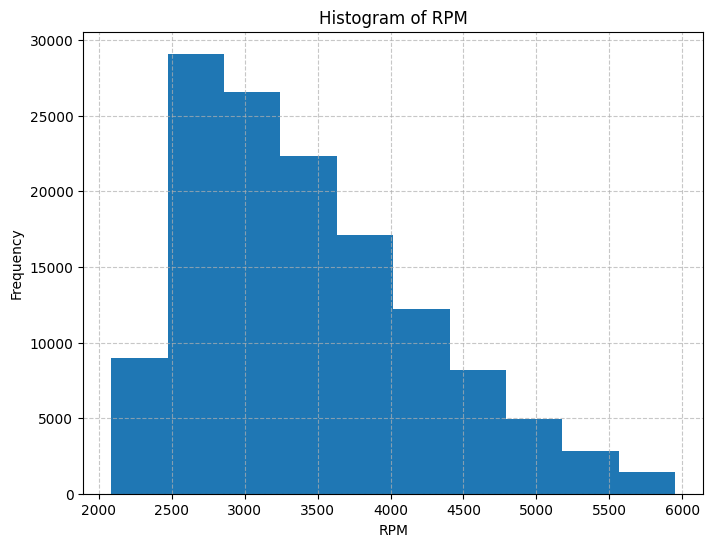

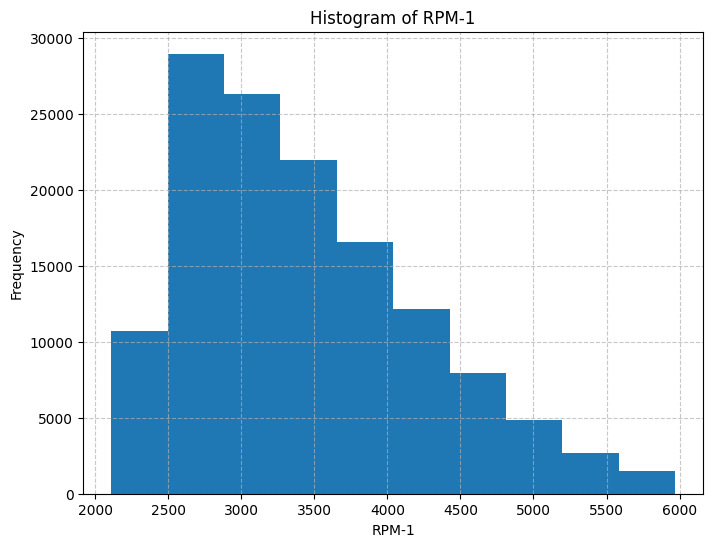

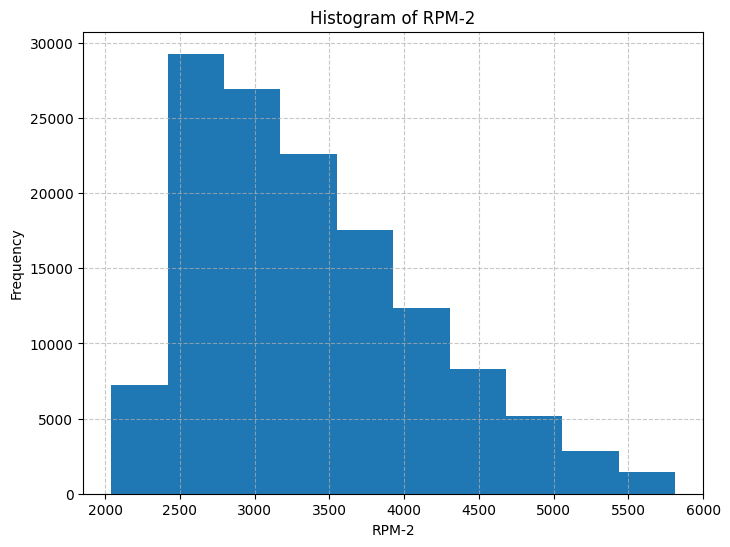

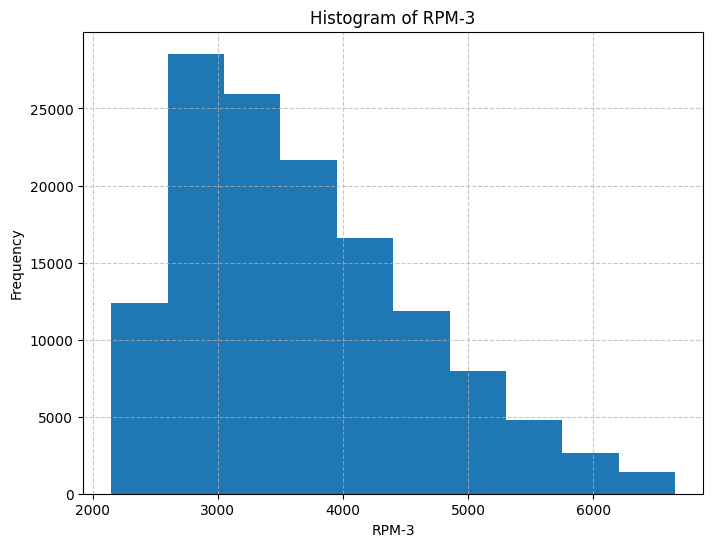

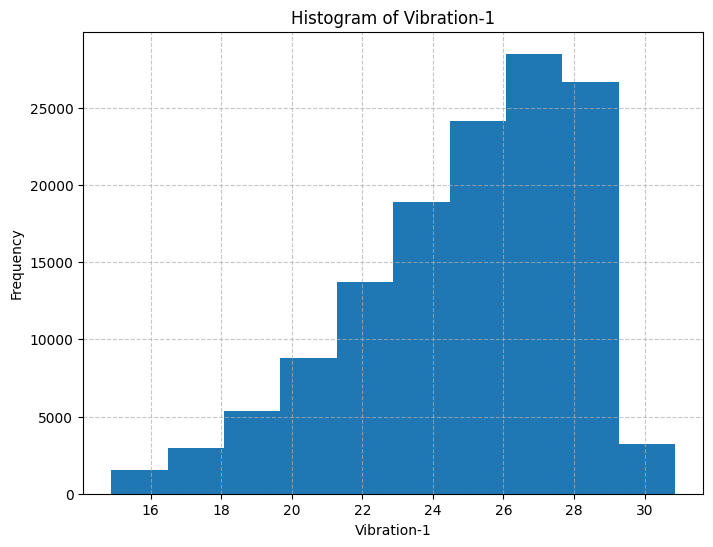

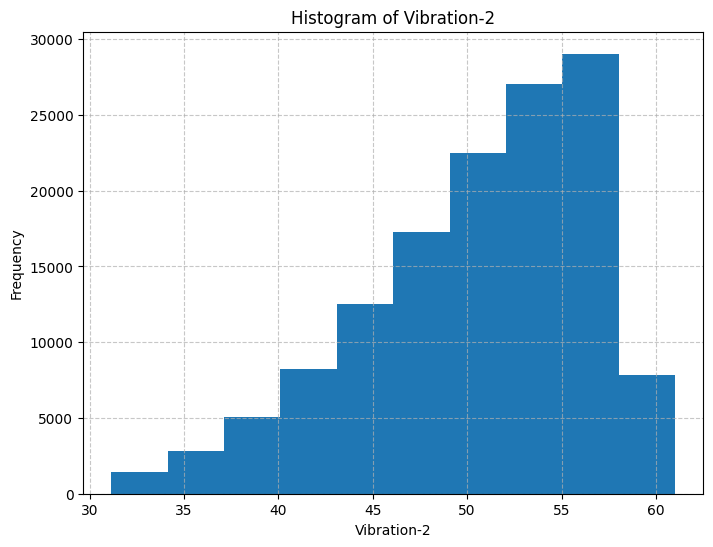

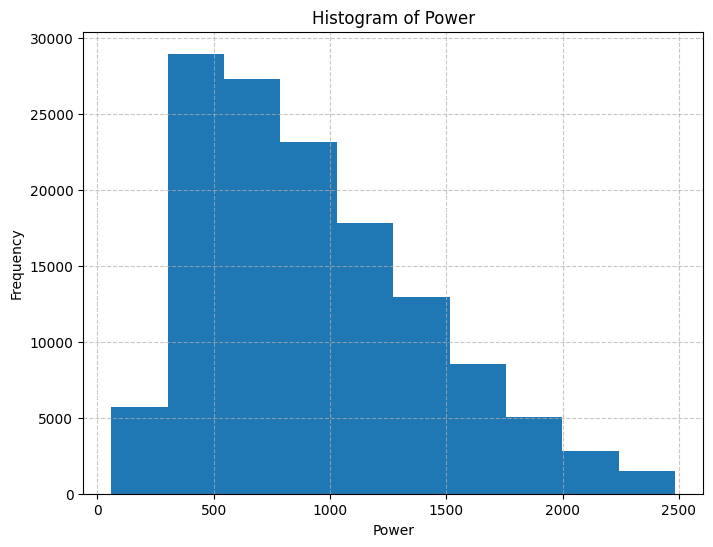

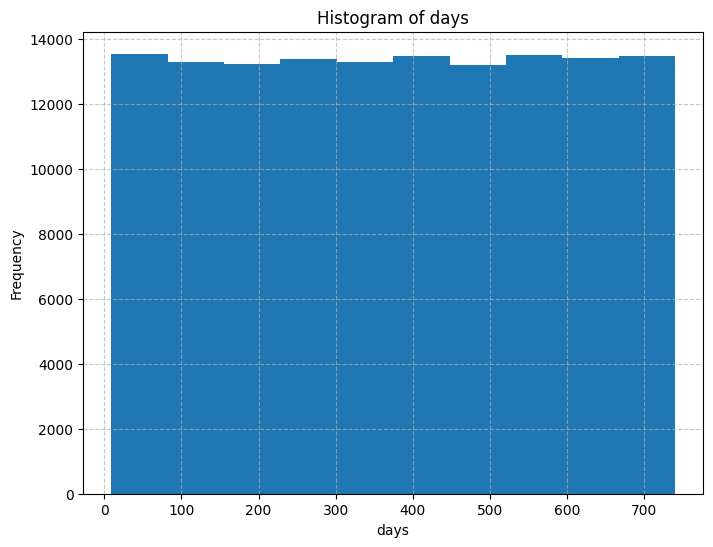

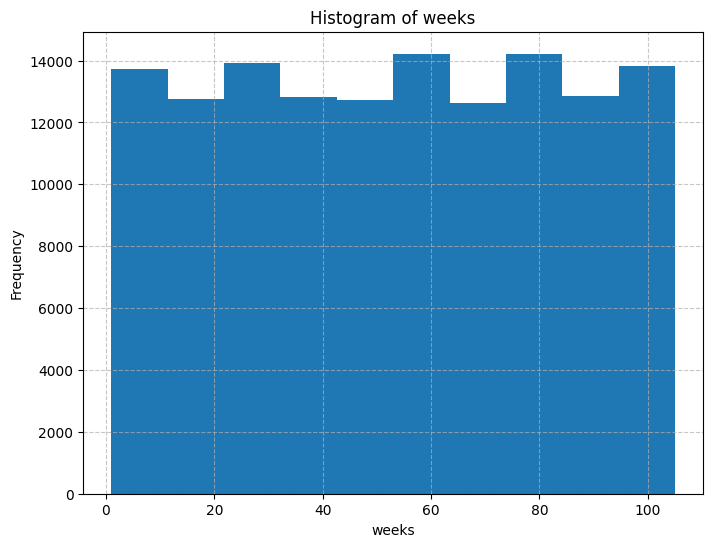

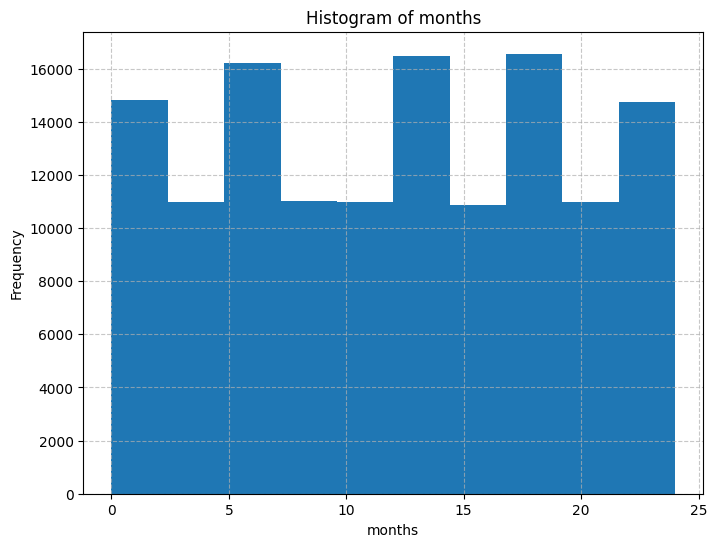

In [14]:
numeric = df_cleanedEDA.select_dtypes(exclude="object")
numeric = numeric.drop(columns =['Status1'])

for column in numeric.columns:
    plt.figure(figsize=(8, 6)) 
    df_cleanedEDA[column].plot(kind="hist")
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

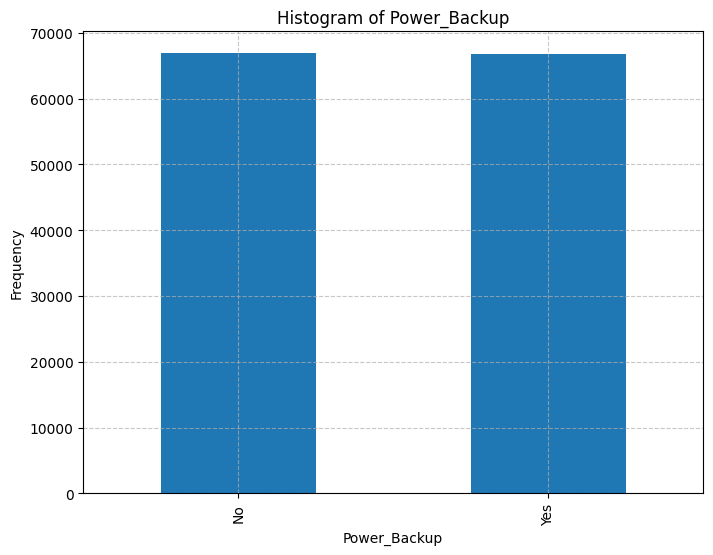

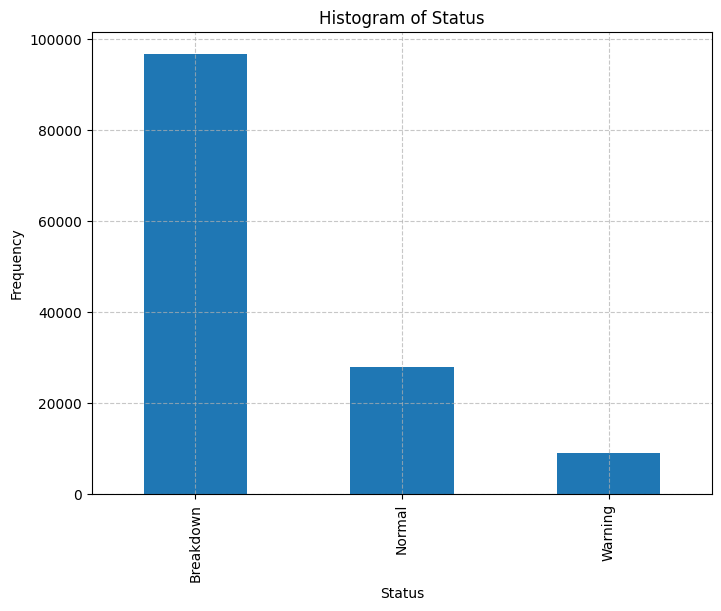

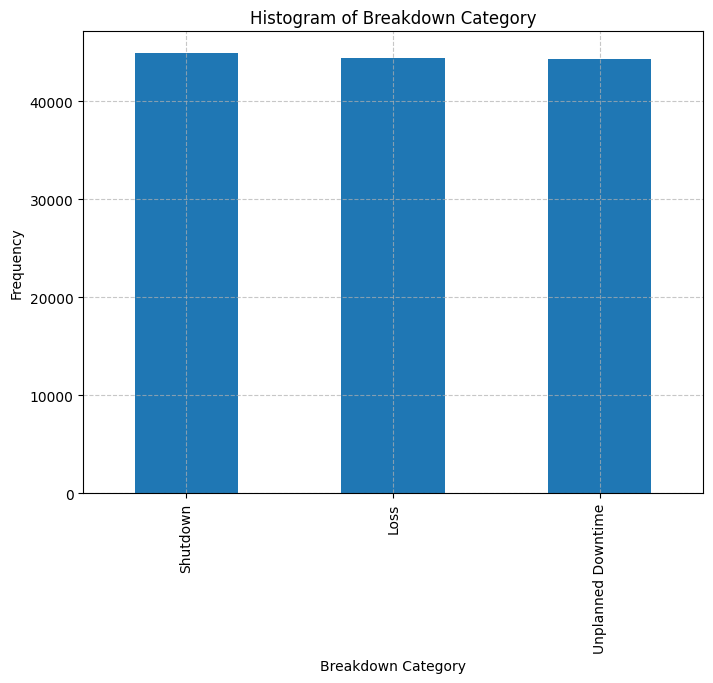

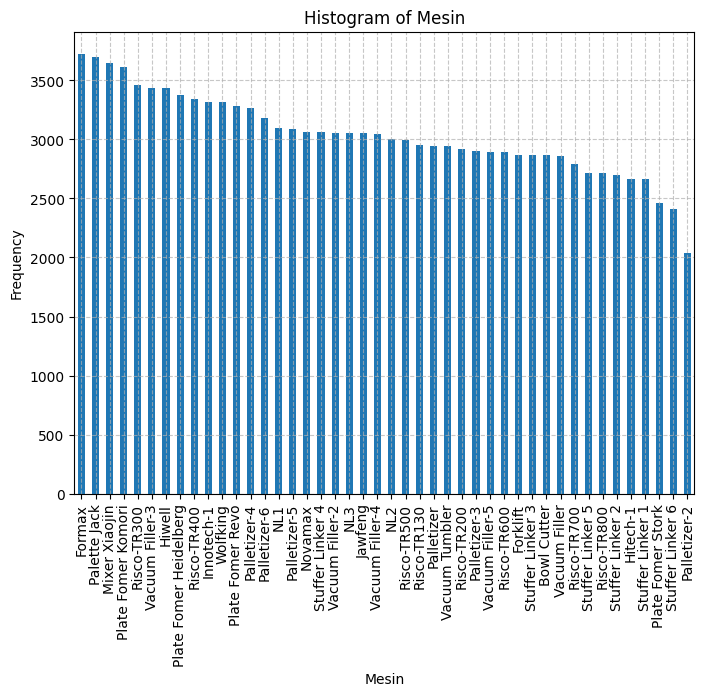

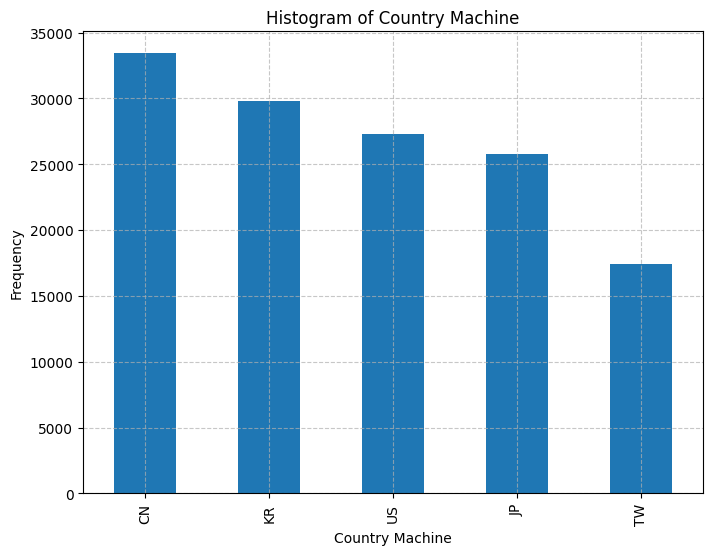

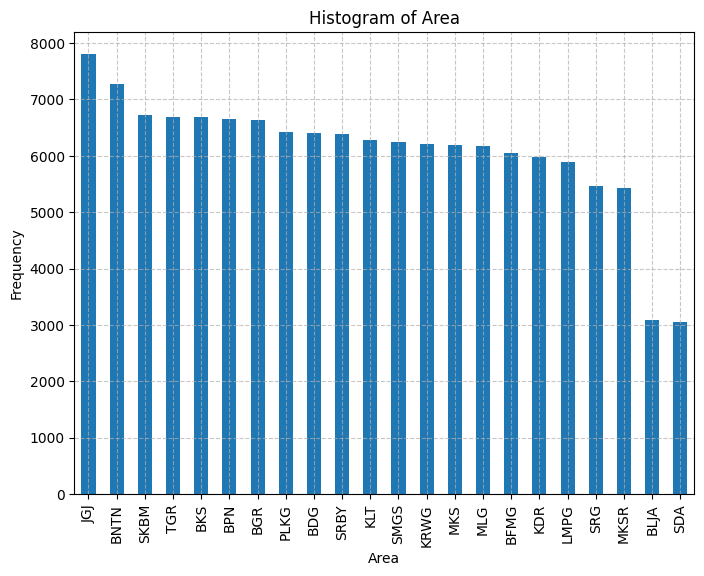

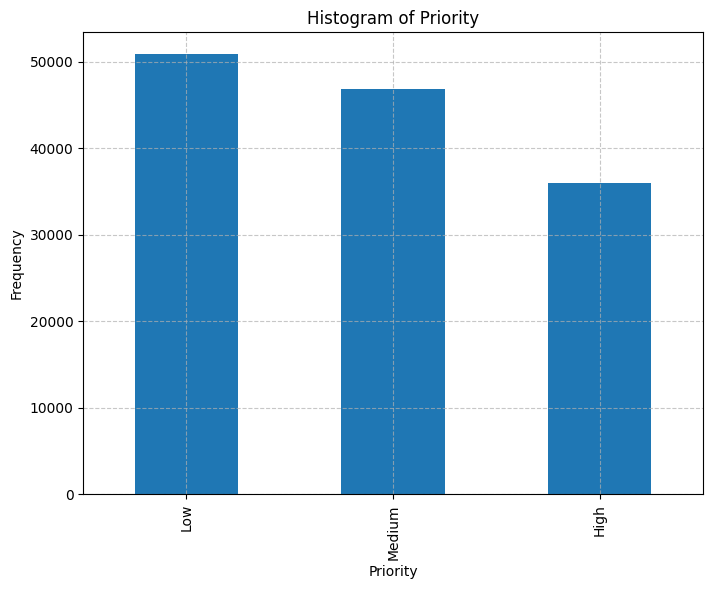

In [15]:
categorical = df_cleanedEDA.select_dtypes(include="object")

for column in categorical.columns:
    plt.figure(figsize=(8, 6)) 
    df_cleanedEDA[column].value_counts().plot(kind="bar")
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

## Visualisasi Dua Variabel

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


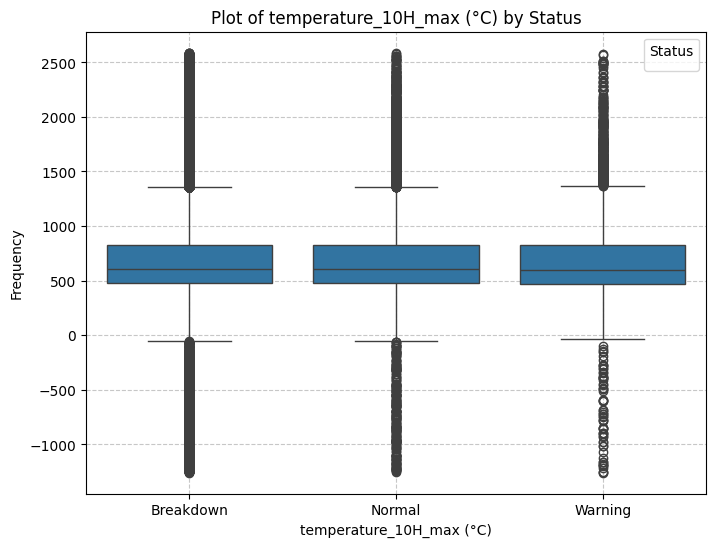

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


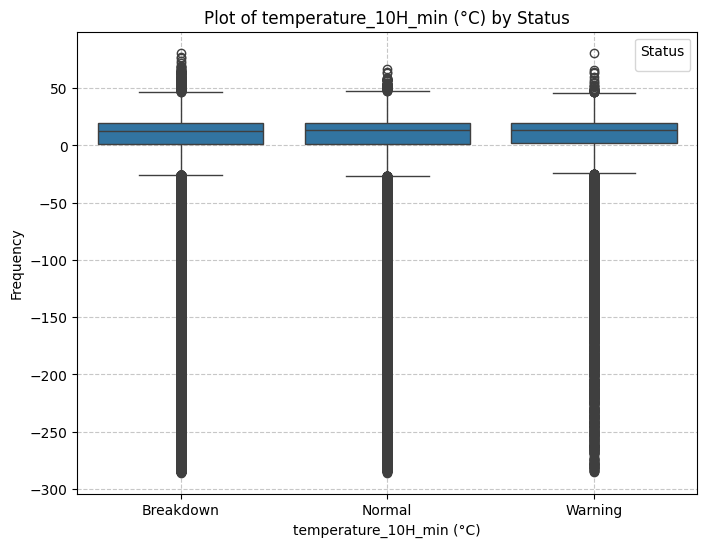

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


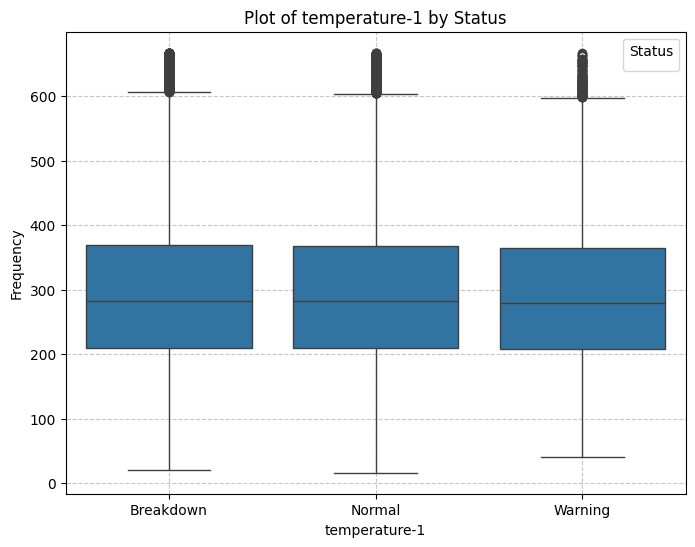

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


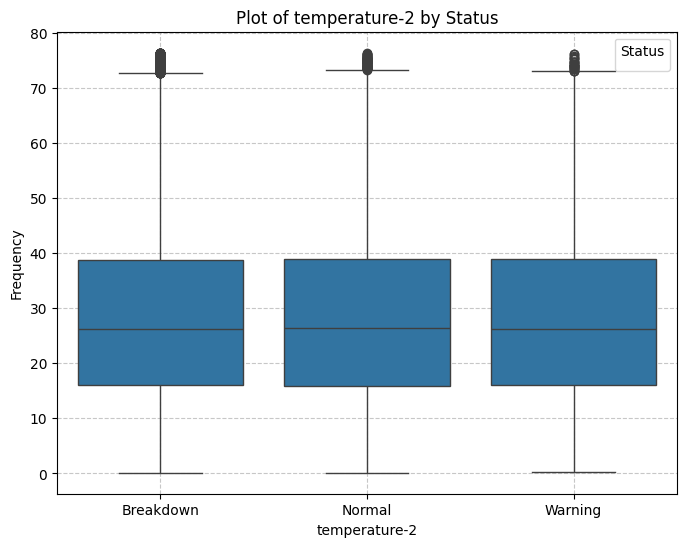

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


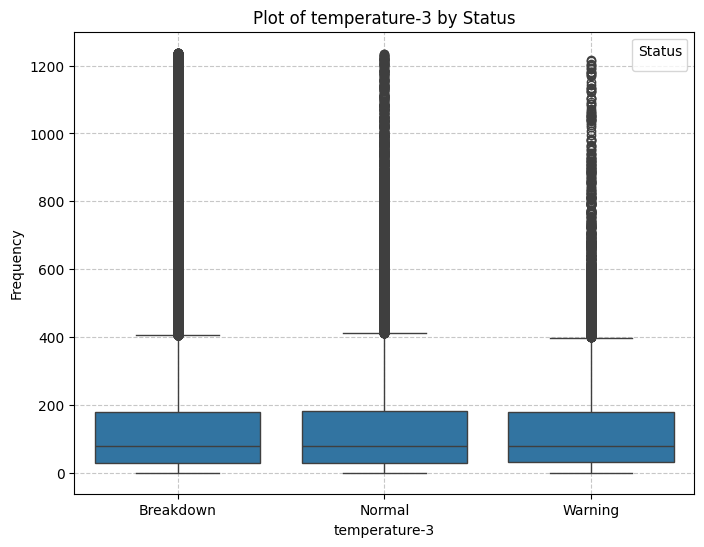

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


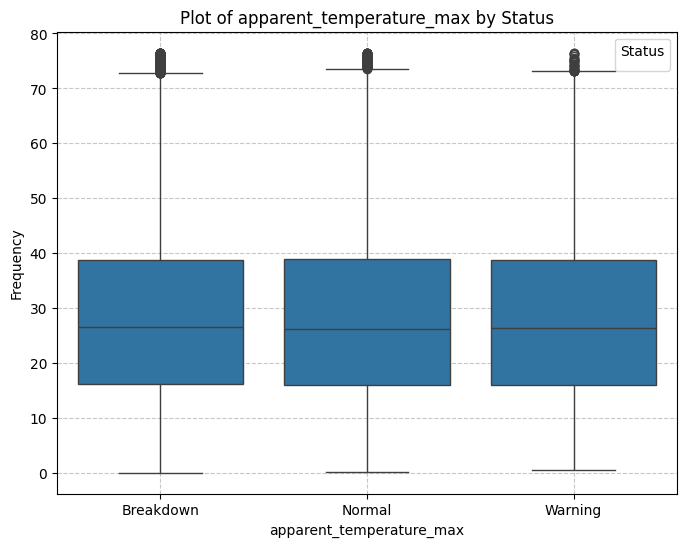

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


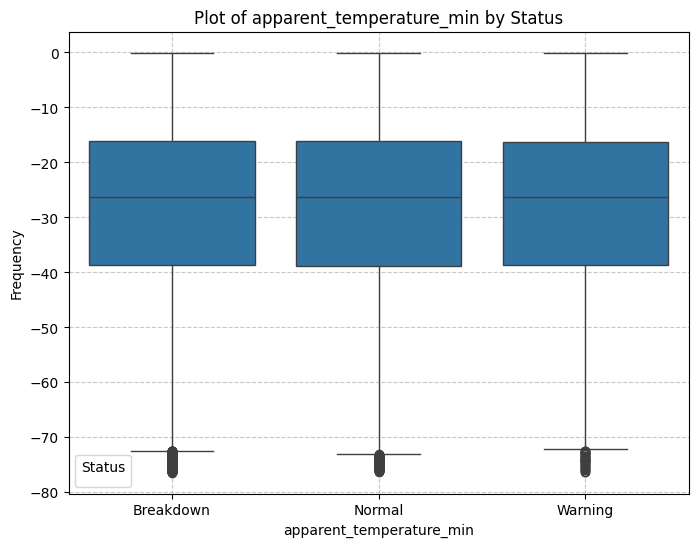

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


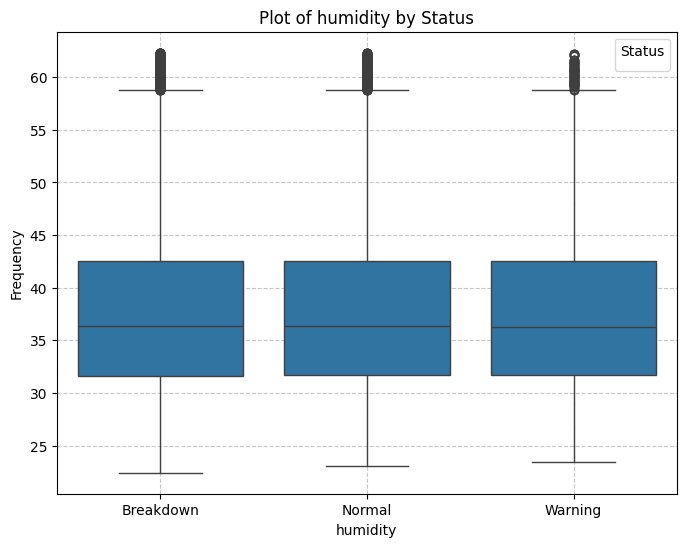

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


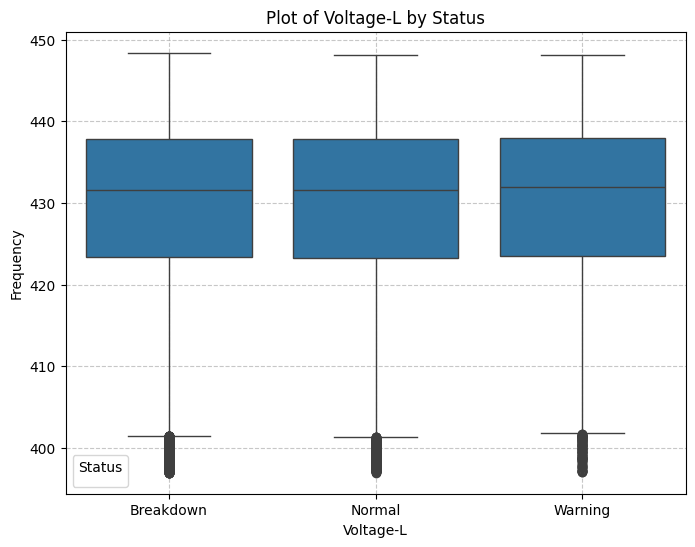

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


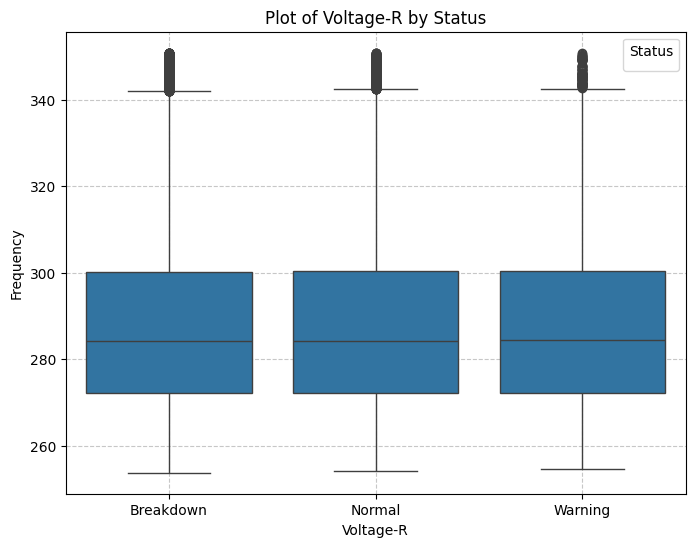

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


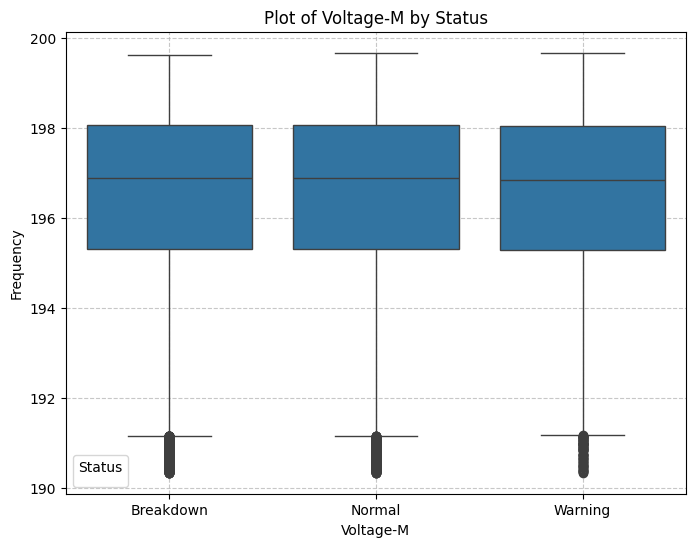

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


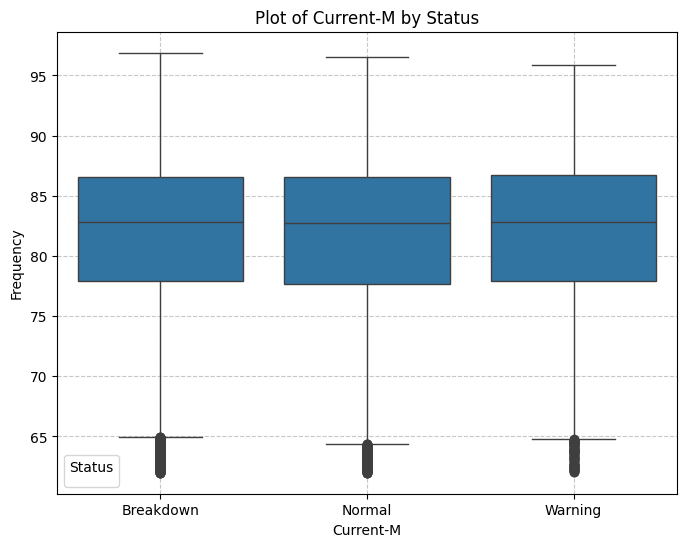

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


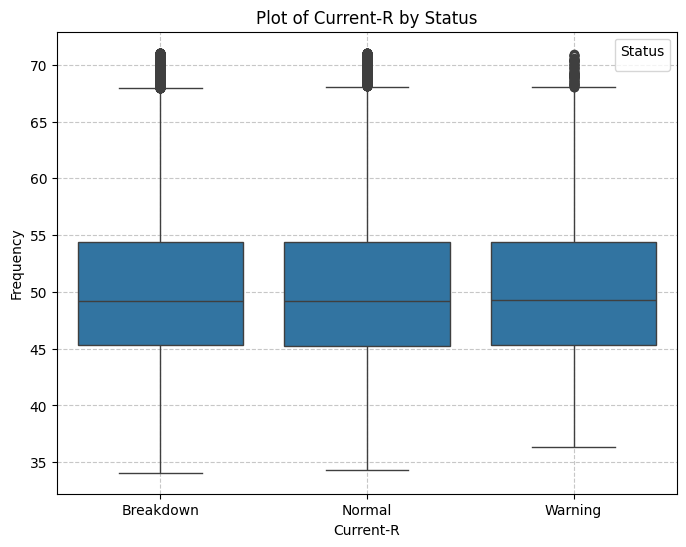

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


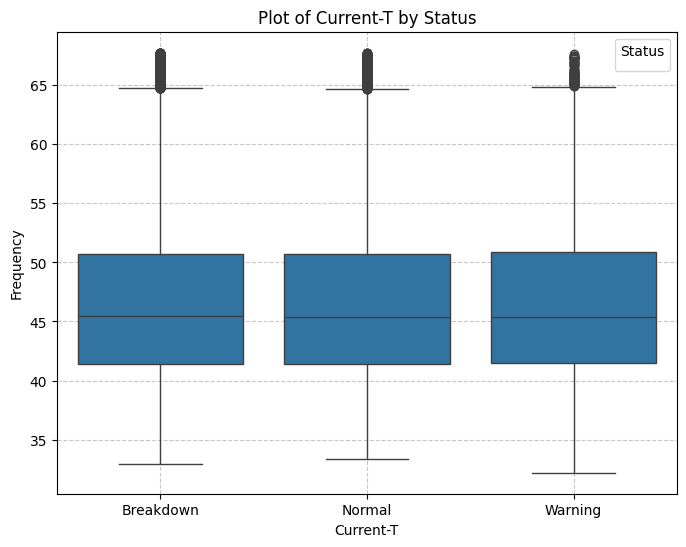

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


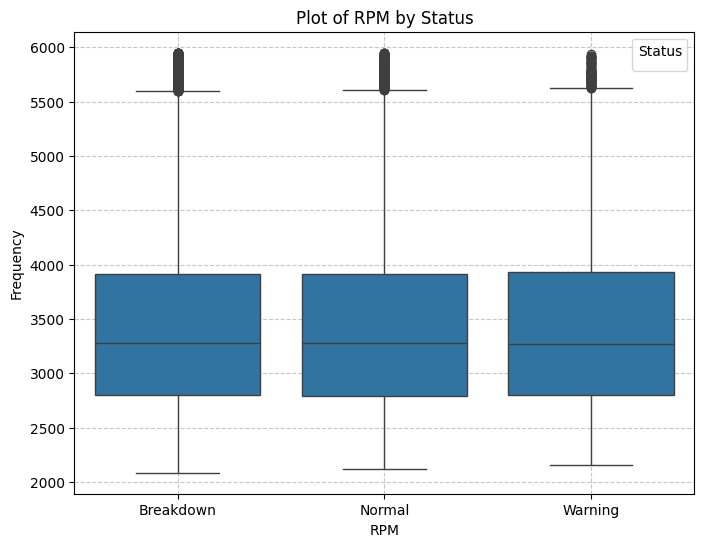

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


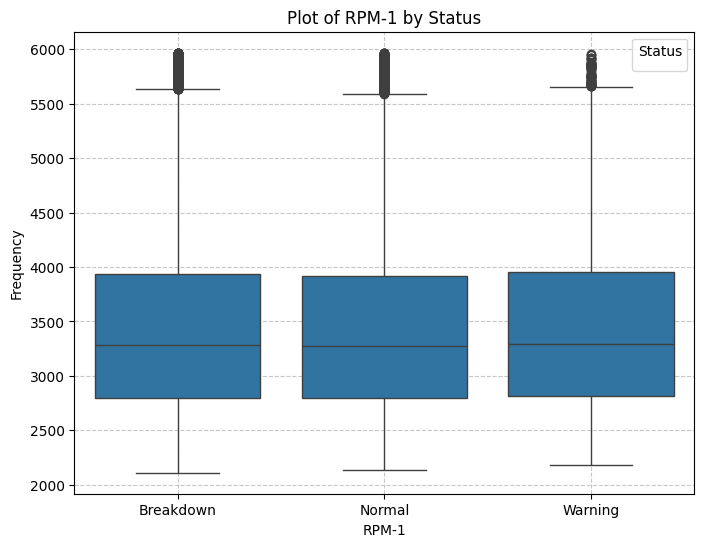

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


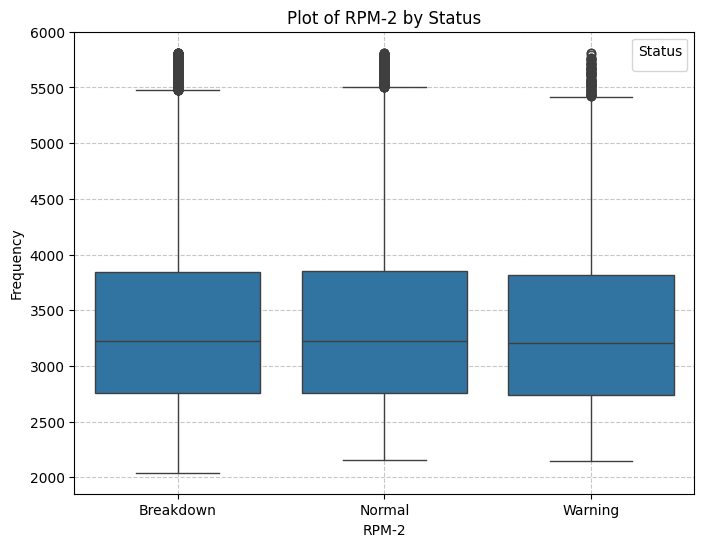

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


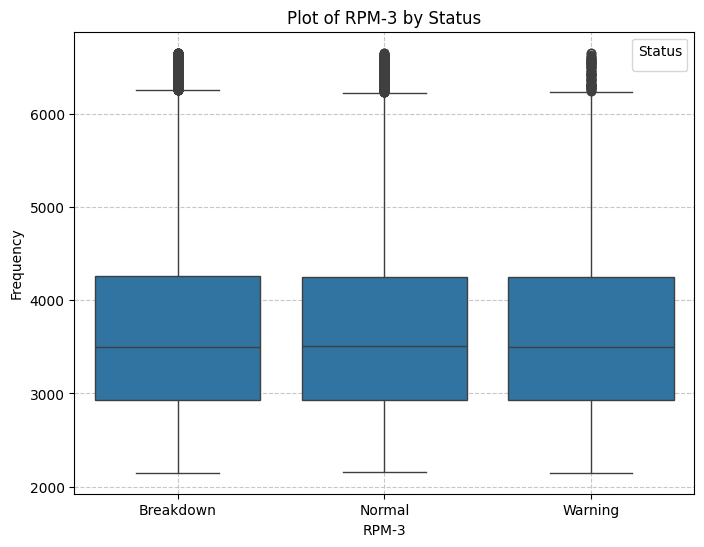

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


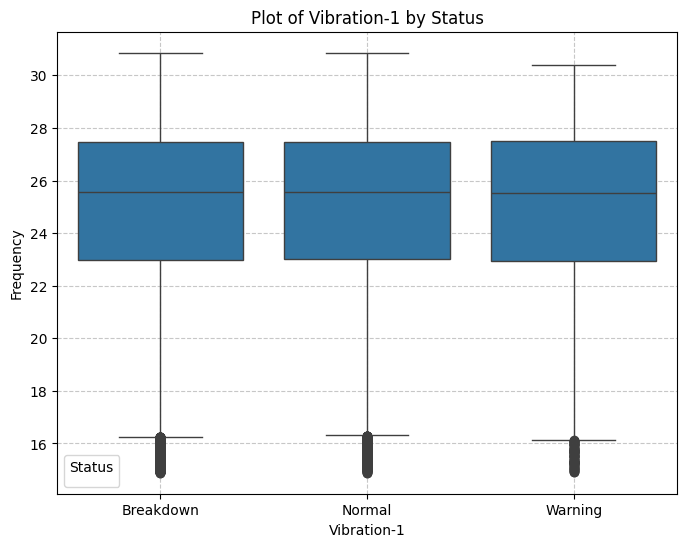

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


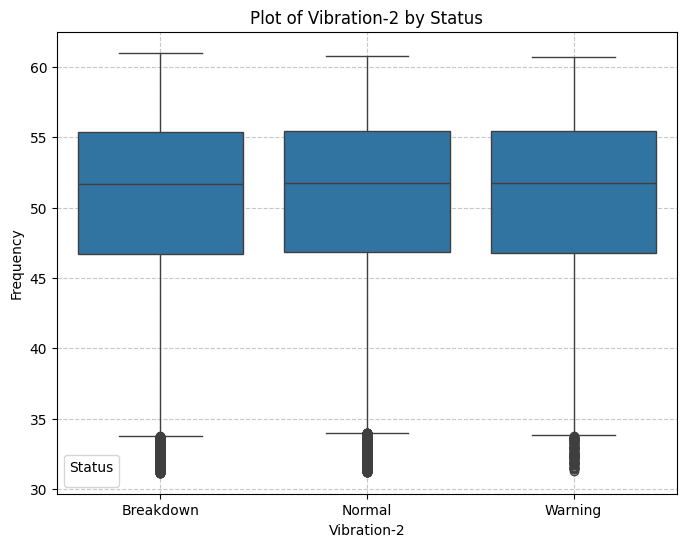

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


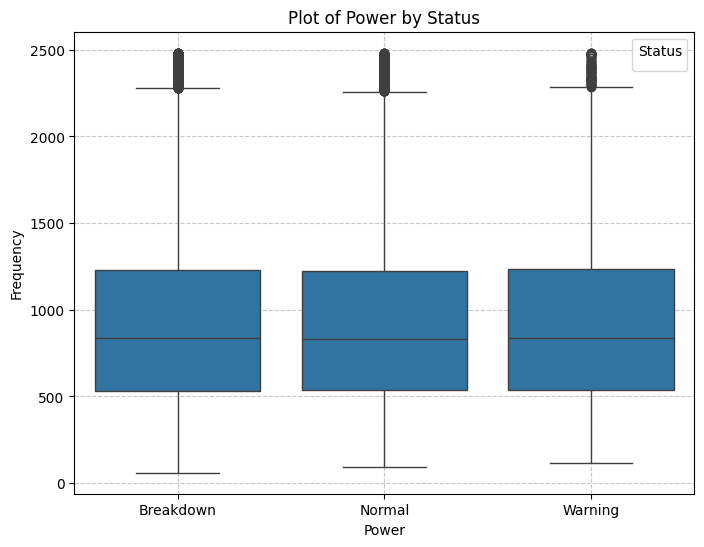

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


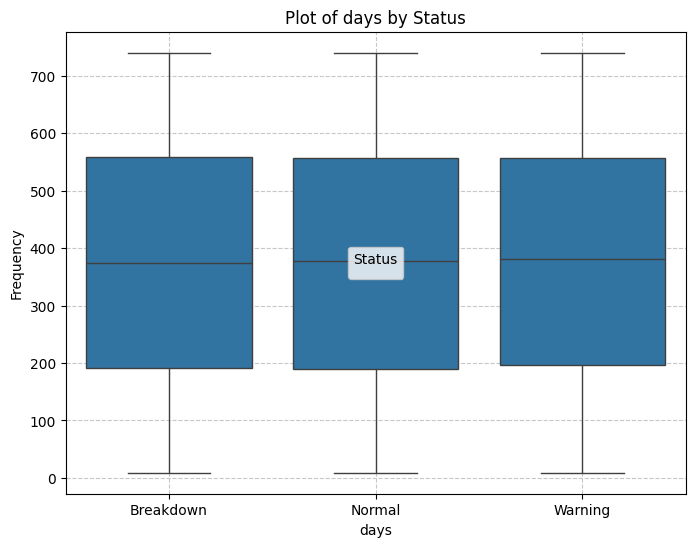

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


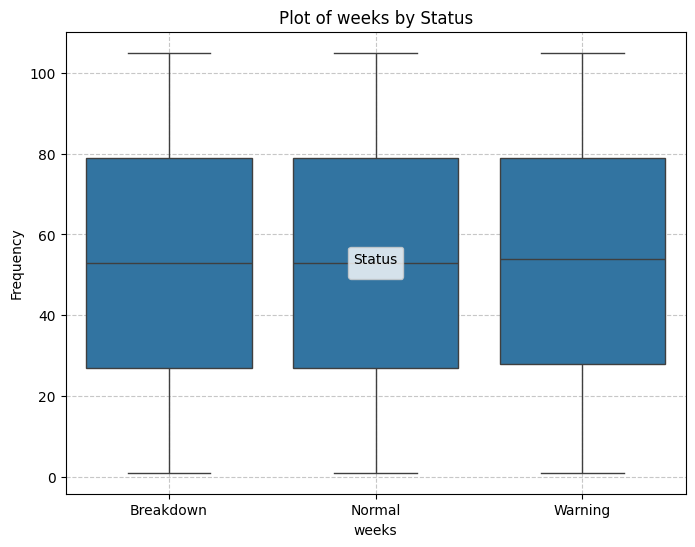

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3501018528.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


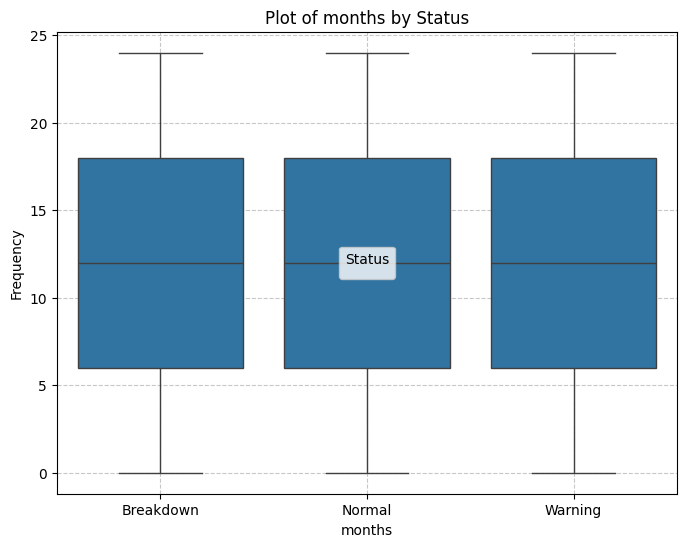

In [16]:
for column in numeric.columns:
    plt.figure(figsize=(8, 6)) 
    sns.boxplot(data=df_cleanedEDA, x='Status', y=column) 
    plt.title(f'Plot of {column} by Status')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend(title='Status')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

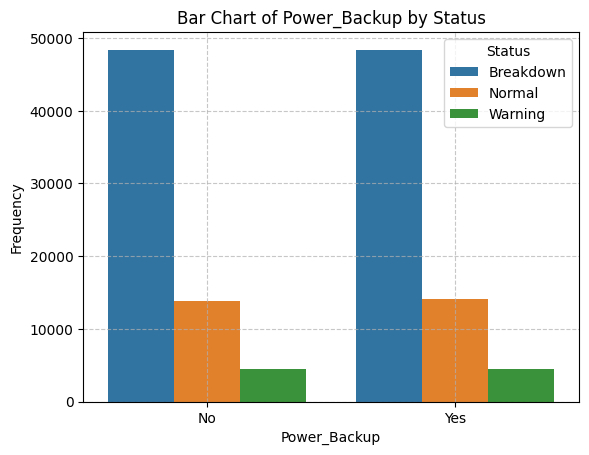

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\1159123726.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Status')


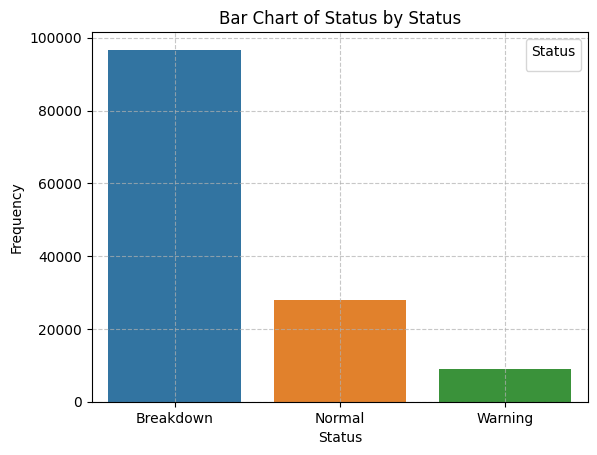

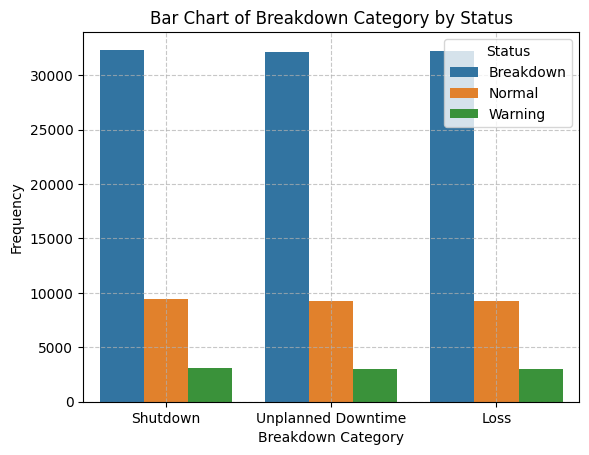

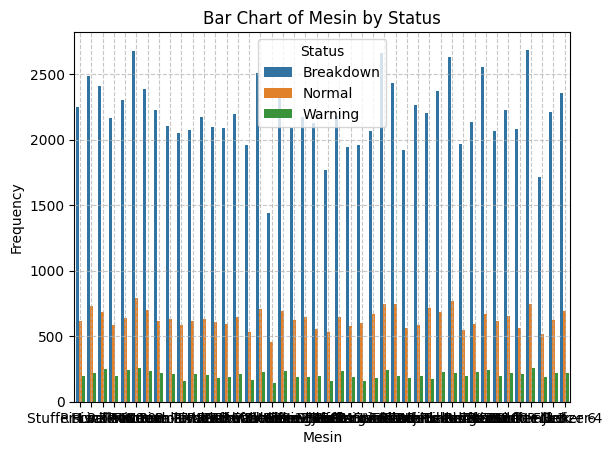

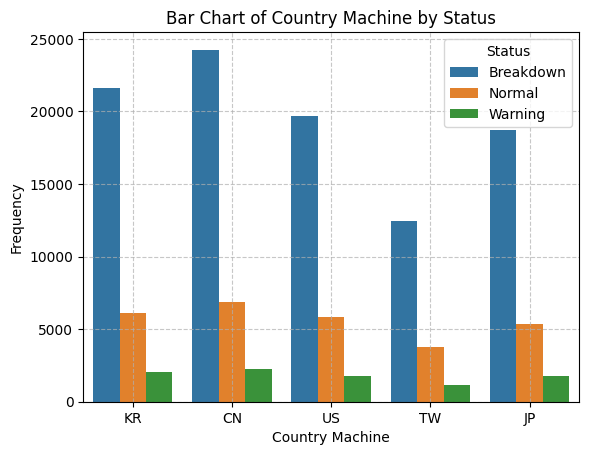

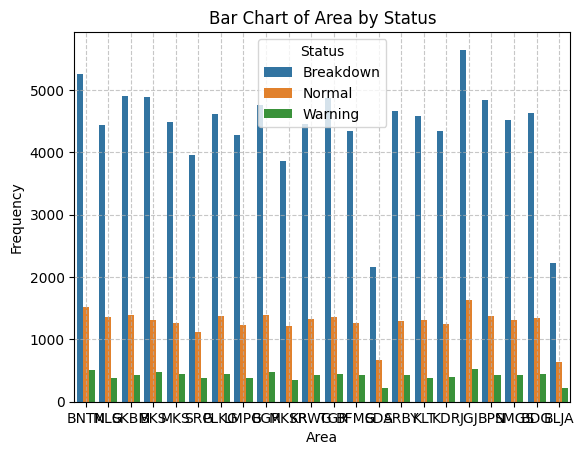

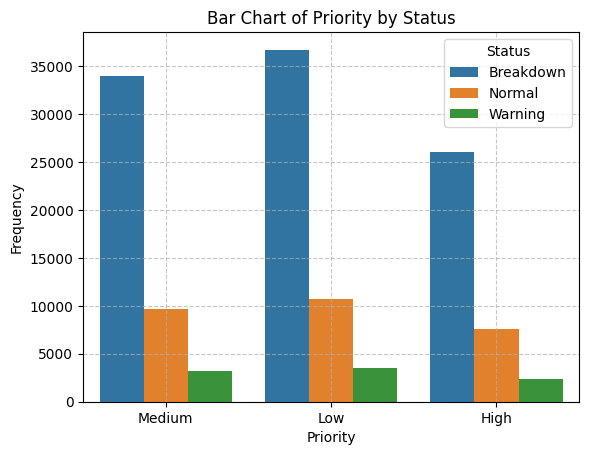

In [17]:
for column in categorical.columns:
    sns.countplot(df_cleanedEDA,x=column, hue ='Status')

    plt.title(f'Bar Chart of {column} by Status')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend(title='Status')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

## Analisis Statistika (Uji SIgnifikansi Asosiasi terhadap Variabel Target)

In [18]:
from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table

categorical= df_cleanedEDA.select_dtypes(include=['object']).drop(columns=["Status"])
ordinal_columns =['Priority']

for column in categorical.columns:
    if column not in ordinal_columns:
        data = pd.crosstab(df_cleanedEDA[column],df_cleanedEDA['Status'])
        contingency_table = Table(data.values)
        chi_square_test = contingency_table.test_nominal_association()
        print(f"The p-value CHI score for {column} and Status",chi_square_test)
    else:
        data = pd.crosstab(df_cleanedEDA[column], df_cleanedEDA['Status'])
        contingency_table = Table(data.values)
        chi_square_test = contingency_table.test_ordinal_association()
        print(f"Chi-Square Ordinal for {column} and Status: {chi_square_test}")

The p-value CHI score for Power_Backup and Status df          2
pvalue      0.5287190209764043
statistic   1.2745962790159657
The p-value CHI score for Breakdown Category and Status df          4
pvalue      0.487739734178259
statistic   3.435587584961942
The p-value CHI score for Mesin and Status df          86
pvalue      0.0542250199304829
statistic   108.04175270108314
The p-value CHI score for Country Machine and Status df          8
pvalue      0.029978498832811673
statistic   17.012565786826453
The p-value CHI score for Area and Status df          42
pvalue      0.25715185512738925
statistic   47.543329945582364
Chi-Square Ordinal for Priority and Status: null_mean   49751.27516959231
null_sd     171.98148323132565
pvalue      0.8103319982871754
statistic   49710.0
zscore      -0.23999775334411685


In [19]:
from scipy.stats import kruskal,kstest,f_oneway

numerical = df_cleanedEDA.select_dtypes(include=['int64','float64'])

for column in numerical.columns:
    Break = df_cleanedEDA[df_cleanedEDA["Status"]=="Breakdown"][column]
    Warning = df_cleanedEDA[df_cleanedEDA["Status"]=="Warning"][column]
    Normal  = df_cleanedEDA[df_cleanedEDA["Status"]=="Normal"][column]

    _, p_value_break = kstest(Break, 'norm')
    _, p_value_warning = kstest(Warning, 'norm')
    _, p_value_normal = kstest(Normal, 'norm')
    
    if p_value_break < 0.05 or p_value_warning < 0.05 or p_value_normal < 0.05:
        p = kruskal(Break, Warning, Normal)
        print(f"The Kruskal-Wallis significance p-value for {column} and Status",p.pvalue)
    else:
        F_statistic, p = f_oneway(Break, Warning, Normal)
        print(f"The ANOVA significance p-value for {column} and Status",p)

The Kruskal-Wallis significance p-value for temperature_10H_max (°C) and Status 0.7553140380861879
The Kruskal-Wallis significance p-value for temperature_10H_min (°C) and Status 0.5459759927950769
The Kruskal-Wallis significance p-value for temperature-1 and Status 0.2108421741256648
The Kruskal-Wallis significance p-value for temperature-2 and Status 0.8600827554881194
The Kruskal-Wallis significance p-value for temperature-3 and Status 0.8335719514828114
The Kruskal-Wallis significance p-value for apparent_temperature_max and Status 0.6179286915113368
The Kruskal-Wallis significance p-value for apparent_temperature_min and Status 0.9478135078028364
The Kruskal-Wallis significance p-value for humidity and Status 0.976348025043975
The Kruskal-Wallis significance p-value for Voltage-L and Status 0.21262344958235144
The Kruskal-Wallis significance p-value for Voltage-R and Status 0.6543944836101003
The Kruskal-Wallis significance p-value for Voltage-M and Status 0.482835546099753
The Kr

## Normalisasi Data

In [20]:
df_cleanedPred.columns[28:]

Index(['BFMG', 'BGR', 'BKS', 'BLJA', 'BNTN', 'BPN', 'JGJ', 'KDR', 'KLT',
       'KRWG', 'LMPG', 'MKS', 'MKSR', 'MLG', 'PLKG', 'SDA', 'SKBM', 'SMGS',
       'SRBY', 'SRG', 'TGR', 'JP', 'KR', 'TW', 'US', 'Forklift', 'Formax',
       'Hitech-1', 'Hiwell', 'Innotech-1', 'Jawfeng', 'Mixer Xiaojin', 'NL1',
       'NL2', 'NL3', 'Novamax', 'Palette Jack', 'Palletizer', 'Palletizer-2',
       'Palletizer-3', 'Palletizer-4', 'Palletizer-5', 'Palletizer-6',
       'Plate Fomer Heidelberg', 'Plate Fomer Komori', 'Plate Fomer Revo',
       'Plate Fomer Stork', 'Risco-TR130', 'Risco-TR200', 'Risco-TR300',
       'Risco-TR400', 'Risco-TR500', 'Risco-TR600', 'Risco-TR700',
       'Risco-TR800', 'Stuffer Linker 1', 'Stuffer Linker 2',
       'Stuffer Linker 3', 'Stuffer Linker 4', 'Stuffer Linker 5',
       'Stuffer Linker 6', 'Vacuum Filler', 'Vacuum Filler-2',
       'Vacuum Filler-3', 'Vacuum Filler-4', 'Vacuum Filler-5',
       'Vacuum Tumbler', 'Wolfking'],
      dtype='object')

In [21]:
def normalize_columns(df):
    target = df[["Status","Status1"]]
    df= df.drop(columns=["Status","Status1"])
    for col in ["Power_Backup", "Priority"]:
        df[col] = df[col].rank() / df[col].rank().max()
    
    preserve_cols = df.iloc[:,26:].columns
    print(preserve_cols)
    preserved_df = df[preserve_cols]
    
    other_cols = df.drop(columns=preserve_cols)
    other_cols = other_cols.drop(columns=["Power_Backup", "Priority"]).columns
    print(other_cols)
    scaler = StandardScaler()
    df[other_cols]= scaler.fit_transform(df[other_cols])
    
    df = pd.concat([df[other_cols],df[["Power_Backup", "Priority"]], preserved_df,target], axis=1)
    return df

In [22]:
df_cleanedPredNorm = normalize_columns(df_cleanedPred)

Index(['BFMG', 'BGR', 'BKS', 'BLJA', 'BNTN', 'BPN', 'JGJ', 'KDR', 'KLT',
       'KRWG', 'LMPG', 'MKS', 'MKSR', 'MLG', 'PLKG', 'SDA', 'SKBM', 'SMGS',
       'SRBY', 'SRG', 'TGR', 'JP', 'KR', 'TW', 'US', 'Forklift', 'Formax',
       'Hitech-1', 'Hiwell', 'Innotech-1', 'Jawfeng', 'Mixer Xiaojin', 'NL1',
       'NL2', 'NL3', 'Novamax', 'Palette Jack', 'Palletizer', 'Palletizer-2',
       'Palletizer-3', 'Palletizer-4', 'Palletizer-5', 'Palletizer-6',
       'Plate Fomer Heidelberg', 'Plate Fomer Komori', 'Plate Fomer Revo',
       'Plate Fomer Stork', 'Risco-TR130', 'Risco-TR200', 'Risco-TR300',
       'Risco-TR400', 'Risco-TR500', 'Risco-TR600', 'Risco-TR700',
       'Risco-TR800', 'Stuffer Linker 1', 'Stuffer Linker 2',
       'Stuffer Linker 3', 'Stuffer Linker 4', 'Stuffer Linker 5',
       'Stuffer Linker 6', 'Vacuum Filler', 'Vacuum Filler-2',
       'Vacuum Filler-3', 'Vacuum Filler-4', 'Vacuum Filler-5',
       'Vacuum Tumbler', 'Wolfking'],
      dtype='object')
Index(['temperatur

In [23]:
df_cleanedPredNorm.head()

,temperature_10H_max (°C),temperature_10H_min (°C),temperature-1,temperature-2,temperature-3,apparent_temperature_max,apparent_temperature_min,humidity,Voltage-L,Voltage-R,...,Stuffer Linker 6,Vacuum Filler,Vacuum Filler-2,Vacuum Filler-3,Vacuum Filler-4,Vacuum Filler-5,Vacuum Tumbler,Wolfking,Status,Status1
0,-2.642552,-0.731460,-0.324868,-0.594051,-0.789549,-0.442491,0.957295,0.424456,-1.051294,-1.054127,...,0,0,0,0,0,0,0,0,2,True
1,-0.376189,0.482965,-0.972137,-0.731278,1.459644,-1.522419,0.940198,-1.318928,-2.765264,0.339455,...,0,0,0,0,0,0,0,0,0,False
2,-0.760331,0.460477,-0.312359,0.335031,-0.253346,-0.900067,-0.685081,-0.914389,-0.049909,1.658259,...,0,0,0,0,0,0,0,0,0,False
3,-0.420057,0.293990,0.502498,-1.086542,-0.700825,0.177077,-1.119496,0.037994,-2.158361,0.669901,...,0,0,0,0,0,0,0,0,0,False
4,0.144814,0.488463,1.009304,1.179576,-0.320343,-0.822367,0.761294,-0.980009,1.194674,0.526778,...,0,0,0,0,0,0,0,0,0,False


# 3. Pemilihan Fitur melalui Analisis Multikolinearitas VIF

In [24]:
preserve_cols = df_cleanedPredNorm.iloc[:,24:].columns

preserved_df =df_cleanedPredNorm[preserve_cols]
df_others = df_cleanedPredNorm.drop(columns=preserve_cols)

In [25]:
print(preserve_cols)
print(preserve_cols.size)

Index(['Power_Backup', 'Priority', 'BFMG', 'BGR', 'BKS', 'BLJA', 'BNTN', 'BPN',
       'JGJ', 'KDR', 'KLT', 'KRWG', 'LMPG', 'MKS', 'MKSR', 'MLG', 'PLKG',
       'SDA', 'SKBM', 'SMGS', 'SRBY', 'SRG', 'TGR', 'JP', 'KR', 'TW', 'US',
       'Forklift', 'Formax', 'Hitech-1', 'Hiwell', 'Innotech-1', 'Jawfeng',
       'Mixer Xiaojin', 'NL1', 'NL2', 'NL3', 'Novamax', 'Palette Jack',
       'Palletizer', 'Palletizer-2', 'Palletizer-3', 'Palletizer-4',
       'Palletizer-5', 'Palletizer-6', 'Plate Fomer Heidelberg',
       'Plate Fomer Komori', 'Plate Fomer Revo', 'Plate Fomer Stork',
       'Risco-TR130', 'Risco-TR200', 'Risco-TR300', 'Risco-TR400',
       'Risco-TR500', 'Risco-TR600', 'Risco-TR700', 'Risco-TR800',
       'Stuffer Linker 1', 'Stuffer Linker 2', 'Stuffer Linker 3',
       'Stuffer Linker 4', 'Stuffer Linker 5', 'Stuffer Linker 6',
       'Vacuum Filler', 'Vacuum Filler-2', 'Vacuum Filler-3',
       'Vacuum Filler-4', 'Vacuum Filler-5', 'Vacuum Tumbler', 'Wolfking',
       'Statu

In [26]:
print(df_others.columns)
print(df_others.columns.size)

Index(['temperature_10H_max (°C)', 'temperature_10H_min (°C)', 'temperature-1',
       'temperature-2', 'temperature-3', 'apparent_temperature_max',
       'apparent_temperature_min', 'humidity', 'Voltage-L', 'Voltage-R',
       'Voltage-M', 'Current-M', 'Current-R', 'Current-T', 'RPM', 'RPM-1',
       'RPM-2', 'RPM-3', 'Vibration-1', 'Vibration-2', 'Power', 'days',
       'weeks', 'months'],
      dtype='object')
24


In [27]:
def calculate_gvif(X):
    gvif = np.array([variance_inflation_factor(X.values, i) for i in range(X.shape[1])])
    gvif_df = pd.DataFrame({'Variable': X.columns, 'GVIF': gvif})
    return gvif_df

gvif_df = calculate_gvif(df_others)

while gvif_df['GVIF'].max() > 5:
    max_vif_col = gvif_df.loc[gvif_df['GVIF'].idxmax(), 'Variable']

    df_others = df_others.drop(max_vif_col, axis=1)
    print(max_vif_col)
    gvif_df = calculate_gvif(df_others)

print("Final GVIF after removing high VIF columns:")
print(gvif_df)

df_cleanedPredNorm = pd.concat([df_others, preserved_df], axis=1)

days
weeks
Final GVIF after removing high VIF columns:
                    Variable      GVIF
0   temperature_10H_max (°C)  1.074523
1   temperature_10H_min (°C)  1.074461
2              temperature-1  1.000195
3              temperature-2  1.000192
4              temperature-3  1.000210
5   apparent_temperature_max  1.000176
6   apparent_temperature_min  1.000177
7                   humidity  1.000198
8                  Voltage-L  1.000128
9                  Voltage-R  1.000104
10                 Voltage-M  1.000111
11                 Current-M  1.000158
12                 Current-R  1.000133
13                 Current-T  1.000167
14                       RPM  1.000209
15                     RPM-1  1.000181
16                     RPM-2  1.000120
17                     RPM-3  1.000108
18               Vibration-1  1.000110
19               Vibration-2  1.000067
20                     Power  1.000176
21                    months  1.000152


In [172]:
df_cleanedPredNorm.head().iloc[:,89:]

,Vacuum Filler-5,Vacuum Tumbler,Wolfking,Status,Status1
0,0,0,0,2,True
1,0,0,0,0,False
2,0,0,0,0,False
3,0,0,0,0,False
4,0,0,0,0,False


In [28]:
print(df_cleanedPredNorm.columns)
print(df_cleanedPredNorm.columns.size)

Index(['temperature_10H_max (°C)', 'temperature_10H_min (°C)', 'temperature-1',
       'temperature-2', 'temperature-3', 'apparent_temperature_max',
       'apparent_temperature_min', 'humidity', 'Voltage-L', 'Voltage-R',
       'Voltage-M', 'Current-M', 'Current-R', 'Current-T', 'RPM', 'RPM-1',
       'RPM-2', 'RPM-3', 'Vibration-1', 'Vibration-2', 'Power', 'months',
       'Power_Backup', 'Priority', 'BFMG', 'BGR', 'BKS', 'BLJA', 'BNTN', 'BPN',
       'JGJ', 'KDR', 'KLT', 'KRWG', 'LMPG', 'MKS', 'MKSR', 'MLG', 'PLKG',
       'SDA', 'SKBM', 'SMGS', 'SRBY', 'SRG', 'TGR', 'JP', 'KR', 'TW', 'US',
       'Forklift', 'Formax', 'Hitech-1', 'Hiwell', 'Innotech-1', 'Jawfeng',
       'Mixer Xiaojin', 'NL1', 'NL2', 'NL3', 'Novamax', 'Palette Jack',
       'Palletizer', 'Palletizer-2', 'Palletizer-3', 'Palletizer-4',
       'Palletizer-5', 'Palletizer-6', 'Plate Fomer Heidelberg',
       'Plate Fomer Komori', 'Plate Fomer Revo', 'Plate Fomer Stork',
       'Risco-TR130', 'Risco-TR200', 'Risco-TR3

# 4. Rekayasa Fitur melalui Principal Component Analysis (PCA)

In [29]:
X= df_cleanedPredNorm.drop(columns=["Status1","Status"])
y_breakdown= df_cleanedPredNorm[["Status1"]].astype(int)
y= df_cleanedPredNorm["Status"]
features = X.columns.tolist() if isinstance(X, pd.DataFrame) else [f'Feature_{i}' for i in range(X.shape[1])]

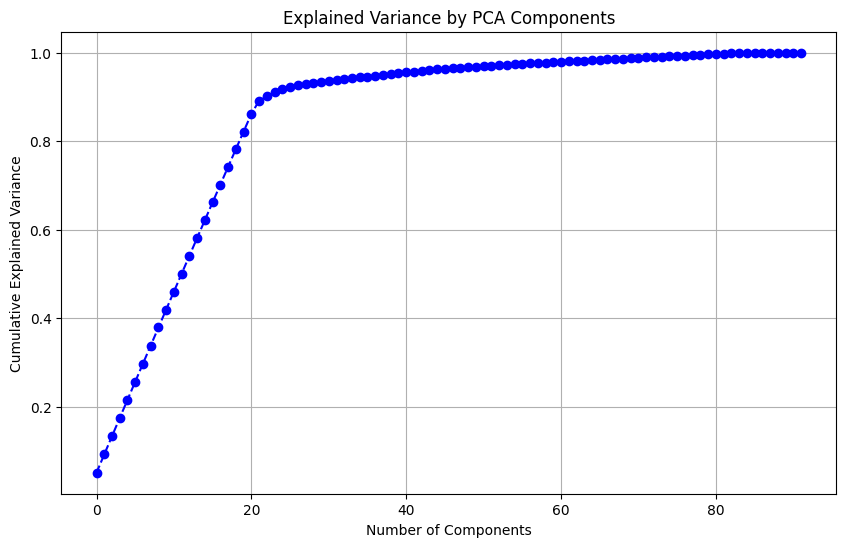

Number of components to retain 80% variance: 20
PCA Component Loadings:
      temperature_10H_max (°C)  temperature_10H_min (°C)  temperature-1  \
PC1                  -0.705846                 -0.705511      -0.007773   
PC2                   0.012191                 -0.003040       0.357060   
PC3                  -0.002617                 -0.030592       0.181957   
PC4                   0.009611                 -0.001305       0.032535   
PC5                  -0.014676                 -0.026627       0.354983   
PC6                  -0.014574                  0.009024      -0.256422   
PC7                  -0.005669                 -0.001412       0.048362   
PC8                   0.001184                 -0.002212      -0.052708   
PC9                   0.017091                  0.023372       0.348520   
PC10                 -0.002933                  0.002672       0.237379   
PC11                  0.001719                 -0.004784       0.045615   
PC12                 -0.0092

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca_features = pca.fit_transform(X)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

n_components = np.argmax(cumulative_variance >= 0.80) + 1  # Retain 80% variance
print(f"Number of components to retain 80% variance: {n_components}")

pca_optimal = PCA(n_components=n_components)
pca_transformed = pca_optimal.fit_transform(X)

pca_columns = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(pca_transformed, columns=pca_columns)
pca_df["Status"] = y

# Display PCA components and their loadings
components_df = pd.DataFrame(
    pca_optimal.components_,
    columns=features,
    index=[f'PC{i+1}' for i in range(n_components)]
)

print("PCA Component Loadings:")
print(components_df)

# 5. Pembagian Data Training dan Data Testing

In [31]:
modellingfeatures = X.columns

In [131]:
pca_df.head().iloc[:,10:]

,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Status
0,-0.731324,-0.725640,1.375104,1.139741,0.583154,1.186383,-0.708040,-0.068422,0.521952,-0.609302,2
1,1.042076,0.476950,0.005122,0.989776,0.301895,2.046232,0.090130,-0.334088,0.015959,-1.302072,0
2,-0.009786,1.284706,-1.314232,0.573685,0.291695,0.990441,0.341007,1.296999,-0.337940,0.146195,0
3,-0.493833,-0.494935,0.143667,0.285287,-0.898482,2.132934,-0.068479,-1.460945,-0.180344,-0.220704,0
4,-0.330280,-0.295634,-1.932337,0.181884,1.240509,-0.423963,0.381743,0.512540,0.371846,0.610062,0


In [33]:
X_train, X_test, y_train_breakdown, y_test_breakdown = train_test_split(pca_df.iloc[:,:-1], y_breakdown, stratify=y_breakdown,test_size=0.2, random_state=42)

df_non_breakdown = pca_df[df_cleanedPredNorm['Status1'] == 0] 
X_non = df_non_breakdown.drop(columns=['Status'])
y_status = df_non_breakdown['Status']

X_train_non, X_test_non, y_train_status, y_test_status = train_test_split(X_non, y_status,stratify=y_status, test_size=0.2, random_state=42)

In [106]:
print("y_train_breakdown:",y_train_breakdown.value_counts())
print("y_test_breakdown:",y_test_breakdown.value_counts())

print("y_train_status:",y_train_status.value_counts())
print("y_test_status:",y_test_status.value_counts())


y_train_breakdown: Status1
1          77375
0          29587
Name: count, dtype: int64
y_test_breakdown: Status1
1          19344
0           7397
Name: count, dtype: int64
y_train_status: Status
0    22355
1     7232
Name: count, dtype: int64
y_test_status: Status
0    5589
1    1808
Name: count, dtype: int64


# 6. Pemodelan dan Hypertuning

## 6.1 Melakukan Hypertuning

In [35]:

params = {
    "n_estimators": [100,200,500],
    "max_depth": [10,20],
    "min_samples_split": [2,3],
    "min_samples_leaf": [1,2],
    "criterion" : ["entropy"]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=params,
    scoring="f1_macro", 
    cv=5, 
    n_jobs=-1, 
)

grid_search.fit(X_train, y_train_breakdown)

best_rf_params = grid_search.best_params_
print(best_rf_params)


C:\Users\andre\anaconda3\envs\test_env_gpu\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [36]:

params =  {
    "n_estimators": [100,200,500],
    "max_depth": [10,20],
    "min_samples_split": [2,3],
    "min_samples_leaf": [1,2],
    "criterion" : ["entropy"]
}

rf_model2 = RandomForestClassifier(random_state=42)

grid_search2 = GridSearchCV(
    estimator=rf_model2,
    param_grid=params,
    scoring="f1_macro", 
    cv=5, 
    n_jobs=-1, 
)

grid_search2.fit(X_train_non, y_train_status)

best_rf_params2 = grid_search2.best_params_
print(best_rf_params2)


{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


## Prediksi Menggunakan Random Forest

#### Model 1

In [40]:
rf_model = RandomForestClassifier(**best_rf_params)
rf_model.fit(X_train, y_train_breakdown)

y_pred = rf_model.predict(X_test)
print("F1 Score:", f1_score(y_test_breakdown, y_pred))

C:\Users\andre\AppData\Local\Temp\ipykernel_5536\3240983420.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train_breakdown)


F1 Score: 0.8394922425952045


#### Model 2

In [41]:
rf_model2 = RandomForestClassifier(**best_rf_params2)
rf_model2.fit(X_train_non, y_train_status)

y_pred2 = rf_model2.predict(X_test_non)
print("F1 Score:", f1_score(y_test_status, y_pred2))

F1 Score: 0.0011055831951354341


# 7. Evaluasi Model

## 7.1 Model Pertama (Breakdown dan Non-Breakdown)

F1 Score: 0.8394922425952045
[[    0  7397]
 [    0 19344]]


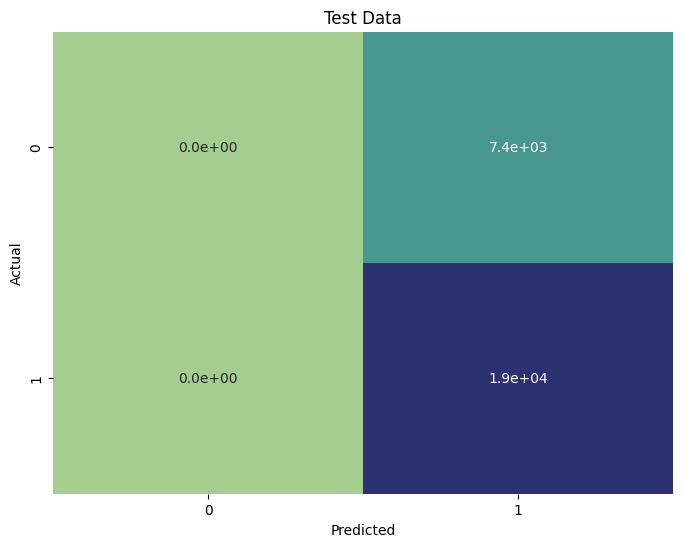

In [42]:
print("F1 Score:", f1_score(y_test_breakdown, y_pred))
cm = confusion_matrix(y_test_breakdown, y_pred)
print(cm)

# Confusion Matrix for Test Data
plt.figure(figsize=(8, 6))  
sns.heatmap(cm, annot=True, fmt=".1e", cmap="crest", cbar=False)
plt.title("Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()  

In [101]:
print("Number of classes:", len(shap_values))
print("Shape of shap_values for class 0:", shap_values[0].shape)
print("Shape of shap_values for class 1:", shap_values[1].shape)
print("Shape of X_test:", X_test.shape)

Number of classes: 26741
Shape of shap_values for class 0: (20, 2)
Shape of shap_values for class 1: (20, 2)
Shape of X_test: (26741, 20)


In [109]:
shap_values.shape

(5, 20, 2)

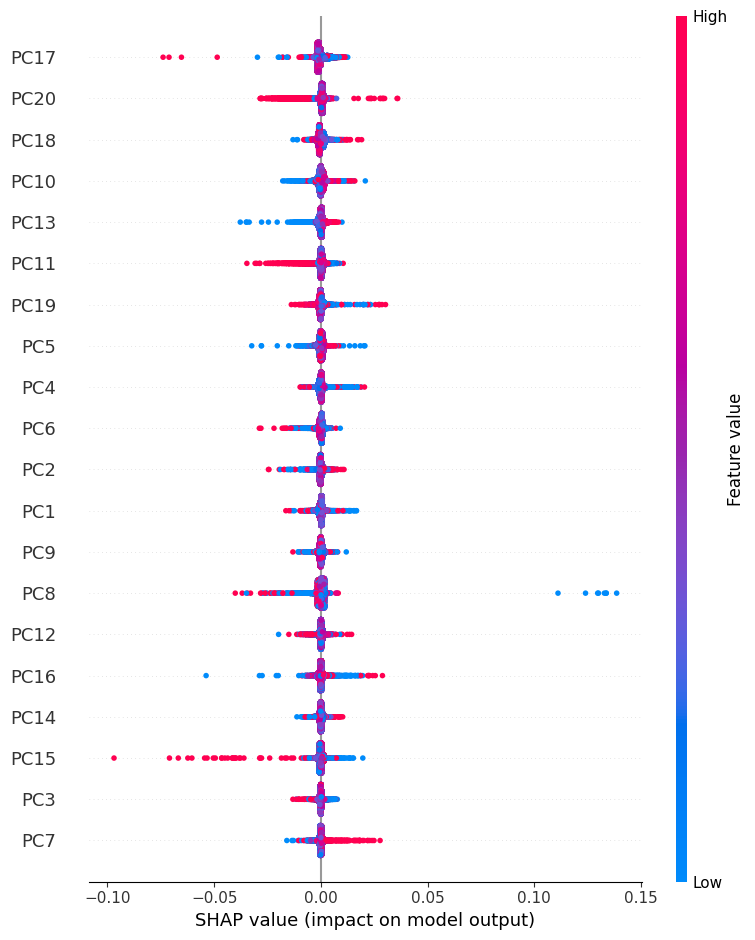

In [111]:
explainer = shap.Explainer(rf_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[:, :, 1], X_test)


## 7.2. Model Kedua (Normal dan Warning)

F1 Score: 0.0011055831951354341
[[5589    0]
 [1807    1]]


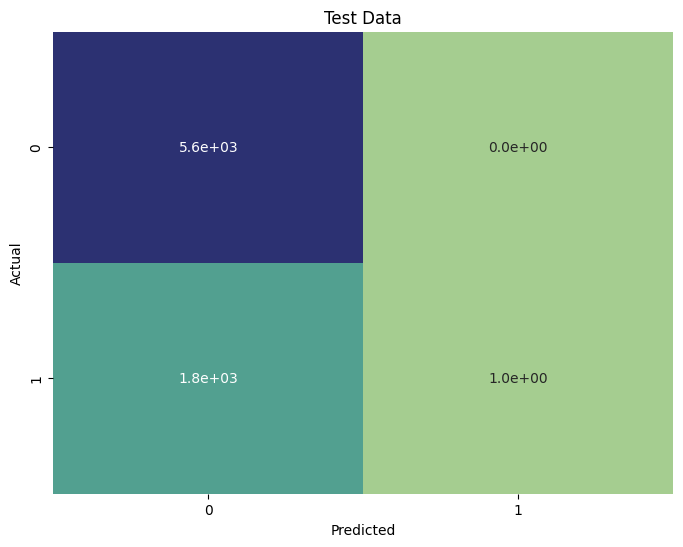

In [43]:
print("F1 Score:", f1_score(y_test_status, y_pred2))
cm2 = confusion_matrix(y_test_status, y_pred2)
print(cm2)


# Confusion Matrix for Test Data
plt.figure(figsize=(8, 6))  
sns.heatmap(cm2, annot=True, fmt=".1e", cmap="crest", cbar=False)
plt.title("Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()  

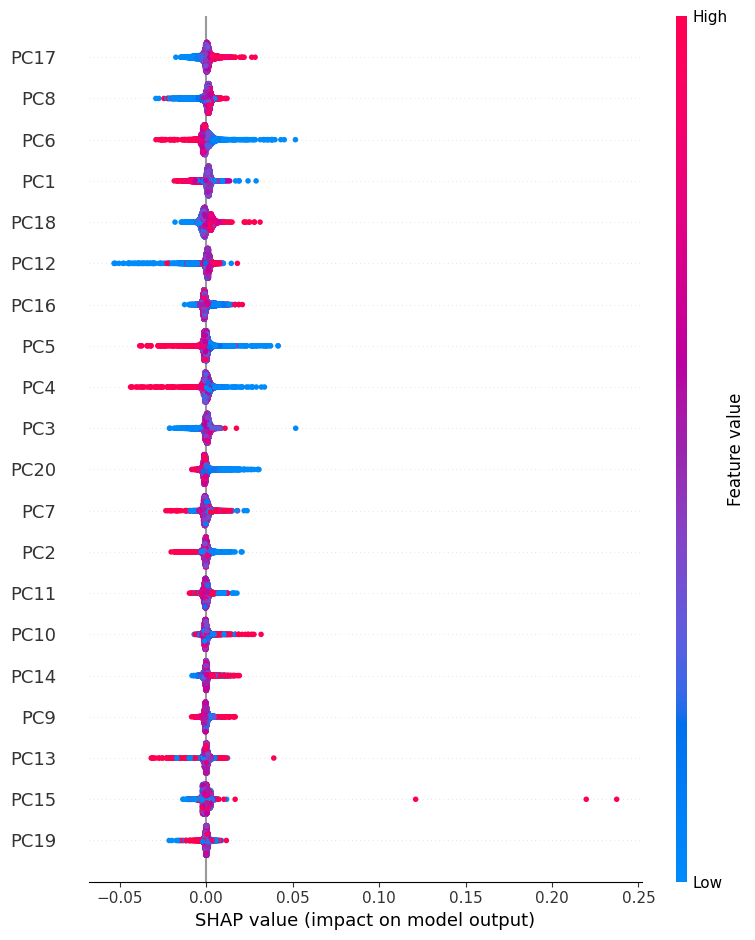

In [114]:
explainer2 = shap.Explainer(rf_model2)
shap_values2 = explainer2.shap_values(X_test_non)

shap.summary_plot(shap_values2[:, :, 1], X_test_non)


In [44]:
overall_f1 = (f1_score(y_test_status, y_pred2) + f1_score(y_test_breakdown, y_pred)) / 2
print("Overall F1-Score: ",overall_f1)

Overall F1-Score:  0.42029891289516996


# SUBMISSION/PENGUMPULAN DATA

In [115]:
machine_area = pd.read_csv("C:/Users/andre/Desktop/Andrew/ANAVADataVers/penyisihan-data-vers-anava-19/Machine-Area.csv")
machine_list = pd.read_csv("C:/Users/andre/Desktop/Andrew/ANAVADataVers/penyisihan-data-vers-anava-19/Machine-List.csv")
area_list = pd.read_csv("C:/Users/andre/Desktop/Andrew/ANAVADataVers/penyisihan-data-vers-anava-19/Area-List.csv")

In [116]:
test = pd.read_csv("C:/Users/andre/Desktop/Andrew/ANAVADataVers/penyisihan-data-vers-anava-19/test.csv")

In [117]:
test.shape

(7000000, 26)

In [118]:
def impute_data(df):
    df=df.drop(columns=["ID_Transaction"])
    numeric = df.drop(columns=["ID_Area","Machine","timestamp","Power_Backup"]).columns
    df.replace(r"^\s*$", np.nan, regex=True, inplace=True)
    for column in df.columns:
        if column in numeric:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        if df[column].dtype in ['int64', 'float64']:  
            median_value = df[column].median()
            df[column] = df[column].fillna(median_value)
        elif df[column].dtype == 'object':  
            mode_value = df[column].mode()[0]
            df[column] = df[column].fillna(mode_value)
        
    return df

def pbackupEncoder(value):
    if value =="Yes":
        return 1
    return 0
    
def priorityEncoder(value):
    if value =="High":
        return 2
    elif value =="Medium":
        return 1
    else:
        return 0

def statusEncoder(value):
    if value =="Breakdown":
        return 2
    elif value =="Warning":
        return 1
    else:
        return 0


def test_wranglingEDA(df):
    df= df.rename(columns={"Machine":"ID_Mesin"})
    df = df.merge(machine_list, on=['ID_Mesin'], how='inner')
    df = df.merge(area_list, on=['ID_Area'], how='inner')
    
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    delta =  datetime(2025,1,10)- df["timestamp"] 
    df["days"] = delta.dt.days
    df["weeks"] = delta.dt.days//7
    df["months"] = delta.dt.days//30

    df = df.drop(columns=["timestamp","ID_Mesin","ID_Area"])
    return df

def test_wranglingPred(df):
    df = pd.concat([df, pd.get_dummies(df["Area"], drop_first=True,dtype=int)],axis=1)
    df = pd.concat([df, pd.get_dummies(df["Country Machine"], drop_first=True,dtype=int)],axis=1)
    df = pd.concat([df, pd.get_dummies(df["Mesin"], drop_first=True,dtype=int)],axis=1) 
    df["Power_Backup"] = df["Power_Backup"].apply(pbackupEncoder)
    df["Priority"] = df["Priority"].apply(priorityEncoder)

    df = df.drop(columns=["Area","Country Machine","Mesin"]) 
    
    return df

def test_normalize_columns(df):
    for col in ["Power_Backup", "Priority"]:
        df[col] = df[col].rank() / df[col].rank().max()
    
    preserve_cols = ['BFMG', 'BGR', 'BKS', 'BLJA', 'BNTN', 'BPN', 'JGJ', 'KDR', 'KLT',
       'KRWG', 'LMPG', 'MKS', 'MKSR', 'MLG', 'PLKG', 'SDA', 'SKBM', 'SMGS',
       'SRBY', 'SRG', 'TGR', 'JP', 'KR', 'TW', 'US', 'Forklift', 'Formax',
       'Hitech-1', 'Hiwell', 'Innotech-1', 'Jawfeng', 'Mixer Xiaojin', 'NL1',
       'NL2', 'NL3', 'Novamax', 'Palette Jack', 'Palletizer', 'Palletizer-2',
       'Palletizer-3', 'Palletizer-4', 'Palletizer-5', 'Palletizer-6',
       'Plate Fomer Heidelberg', 'Plate Fomer Komori', 'Plate Fomer Revo',
       'Plate Fomer Stork', 'Risco-TR130', 'Risco-TR200', 'Risco-TR300',
       'Risco-TR400', 'Risco-TR500', 'Risco-TR600', 'Risco-TR700',
       'Risco-TR800', 'Stuffer Linker 1', 'Stuffer Linker 2',
       'Stuffer Linker 3', 'Stuffer Linker 4', 'Stuffer Linker 5',
       'Stuffer Linker 6', 'Vacuum Filler', 'Vacuum Filler-2',
       'Vacuum Filler-3', 'Vacuum Filler-4', 'Vacuum Filler-5',
       'Vacuum Tumbler', 'Wolfking']
    print(preserve_cols)
    for cols in preserve_cols:
        if cols in df.columns:
            continue
        else:
            df[cols] = 0
        
    preserved_df = df[preserve_cols]
    df.head()
    
    other_cols = df.drop(columns=preserve_cols)
    other_cols = other_cols.drop(columns=["Power_Backup", "Priority"]).columns
    print(other_cols)
    scaler = StandardScaler()
    df[other_cols]= scaler.fit_transform(df[other_cols])
    
    df = pd.concat([df[other_cols],df[["Power_Backup", "Priority"]], preserved_df], axis=1)
    return df

In [119]:
test_cleaned = impute_data(test)

In [120]:
test_cleaned = test_wranglingEDA(test_cleaned)

In [121]:
test_cleaned.head()

,temperature_10H_max (°C),temperature_10H_min (°C),temperature-1,temperature-2,temperature-3,apparent_temperature_max,apparent_temperature_min,humidity,Voltage-L,Voltage-R,...,Vibration-2,Power,Power_Backup,Mesin,Country Machine,Area,Priority,days,weeks,months
0,-3322.323689,-221.677374,166.922400,48.626853,79.765145,13.669606,-43.911657,33.920209,431.082875,334.433644,...,57.225787,1087.088945,Yes,Innotech-1,KR,MKS,High,726,103,24
1,719.700365,12.249862,400.678538,14.421425,53.740342,22.297932,-36.569152,38.730079,430.869071,276.429026,...,55.341528,840.696939,Yes,Risco-TR300,CN,BDG,Medium,365,52,12
2,718.918630,23.645588,456.535206,39.053999,16.800056,24.194078,-19.180181,32.308273,427.479001,289.654479,...,44.386573,1524.919220,Yes,Palletizer-4,CN,MKS,Medium,311,44,10
3,593.678709,19.380103,283.522329,7.974228,118.629967,14.245905,-26.434945,28.081321,431.504954,307.937247,...,50.735681,469.725303,Yes,Risco-TR500,US,BPN,Medium,50,7,1
4,644.119485,27.352616,628.335427,56.588644,5.298174,31.684072,-24.182661,33.968450,406.820344,261.973490,...,52.317770,1325.416708,No,Plate Fomer Revo,JP,MLG,High,298,42,9


In [122]:
test_cleaned = test_wranglingPred(test_cleaned)

In [123]:
test_cleaned.head()

,temperature_10H_max (°C),temperature_10H_min (°C),temperature-1,temperature-2,temperature-3,apparent_temperature_max,apparent_temperature_min,humidity,Voltage-L,Voltage-R,...,Stuffer Linker 4,Stuffer Linker 5,Stuffer Linker 6,Vacuum Filler,Vacuum Filler-2,Vacuum Filler-3,Vacuum Filler-4,Vacuum Filler-5,Vacuum Tumbler,Wolfking
0,-3322.323689,-221.677374,166.922400,48.626853,79.765145,13.669606,-43.911657,33.920209,431.082875,334.433644,...,0,0,0,0,0,0,0,0,0,0
1,719.700365,12.249862,400.678538,14.421425,53.740342,22.297932,-36.569152,38.730079,430.869071,276.429026,...,0,0,0,0,0,0,0,0,0,0
2,718.918630,23.645588,456.535206,39.053999,16.800056,24.194078,-19.180181,32.308273,427.479001,289.654479,...,0,0,0,0,0,0,0,0,0,0
3,593.678709,19.380103,283.522329,7.974228,118.629967,14.245905,-26.434945,28.081321,431.504954,307.937247,...,0,0,0,0,0,0,0,0,0,0
4,644.119485,27.352616,628.335427,56.588644,5.298174,31.684072,-24.182661,33.968450,406.820344,261.973490,...,0,0,0,0,0,0,0,0,0,0


In [124]:
test_cleaned.columns

Index(['temperature_10H_max (°C)', 'temperature_10H_min (°C)', 'temperature-1',
       'temperature-2', 'temperature-3', 'apparent_temperature_max',
       'apparent_temperature_min', 'humidity', 'Voltage-L', 'Voltage-R',
       'Voltage-M', 'Current-M', 'Current-R', 'Current-T', 'RPM', 'RPM-1',
       'RPM-2', 'RPM-3', 'Vibration-1', 'Vibration-2', 'Power', 'Power_Backup',
       'Priority', 'days', 'weeks', 'months', 'BFMG', 'BGR', 'BKS', 'BLJA',
       'BNTN', 'BPN', 'JGJ', 'KDR', 'KLT', 'KRWG', 'LMPG', 'MKS', 'MKSR',
       'MLG', 'PLKG', 'SDA', 'SKBM', 'SMGS', 'SRBY', 'SRG', 'TGR', 'JP', 'KR',
       'TW', 'US', 'Forklift', 'Formax', 'Hitech-1', 'Hiwell', 'Innotech-1',
       'Jawfeng', 'Mixer Xiaojin', 'NL1', 'NL2', 'NL3', 'Novamax',
       'Palette Jack', 'Palletizer', 'Palletizer-2', 'Palletizer-3',
       'Palletizer-4', 'Palletizer-5', 'Palletizer-6',
       'Plate Fomer Heidelberg', 'Plate Fomer Komori', 'Plate Fomer Revo',
       'Plate Fomer Stork', 'Risco-TR130', 'Risco-T

In [125]:
test_cleaned_norm = test_normalize_columns(test_cleaned)

['BFMG', 'BGR', 'BKS', 'BLJA', 'BNTN', 'BPN', 'JGJ', 'KDR', 'KLT', 'KRWG', 'LMPG', 'MKS', 'MKSR', 'MLG', 'PLKG', 'SDA', 'SKBM', 'SMGS', 'SRBY', 'SRG', 'TGR', 'JP', 'KR', 'TW', 'US', 'Forklift', 'Formax', 'Hitech-1', 'Hiwell', 'Innotech-1', 'Jawfeng', 'Mixer Xiaojin', 'NL1', 'NL2', 'NL3', 'Novamax', 'Palette Jack', 'Palletizer', 'Palletizer-2', 'Palletizer-3', 'Palletizer-4', 'Palletizer-5', 'Palletizer-6', 'Plate Fomer Heidelberg', 'Plate Fomer Komori', 'Plate Fomer Revo', 'Plate Fomer Stork', 'Risco-TR130', 'Risco-TR200', 'Risco-TR300', 'Risco-TR400', 'Risco-TR500', 'Risco-TR600', 'Risco-TR700', 'Risco-TR800', 'Stuffer Linker 1', 'Stuffer Linker 2', 'Stuffer Linker 3', 'Stuffer Linker 4', 'Stuffer Linker 5', 'Stuffer Linker 6', 'Vacuum Filler', 'Vacuum Filler-2', 'Vacuum Filler-3', 'Vacuum Filler-4', 'Vacuum Filler-5', 'Vacuum Tumbler', 'Wolfking']
Index(['temperature_10H_max (°C)', 'temperature_10H_min (°C)', 'temperature-1',
       'temperature-2', 'temperature-3', 'apparent_tempera

In [126]:
test_cleaned_norm.columns

Index(['temperature_10H_max (°C)', 'temperature_10H_min (°C)', 'temperature-1',
       'temperature-2', 'temperature-3', 'apparent_temperature_max',
       'apparent_temperature_min', 'humidity', 'Voltage-L', 'Voltage-R',
       'Voltage-M', 'Current-M', 'Current-R', 'Current-T', 'RPM', 'RPM-1',
       'RPM-2', 'RPM-3', 'Vibration-1', 'Vibration-2', 'Power', 'days',
       'weeks', 'months', 'Power_Backup', 'Priority', 'BFMG', 'BGR', 'BKS',
       'BLJA', 'BNTN', 'BPN', 'JGJ', 'KDR', 'KLT', 'KRWG', 'LMPG', 'MKS',
       'MKSR', 'MLG', 'PLKG', 'SDA', 'SKBM', 'SMGS', 'SRBY', 'SRG', 'TGR',
       'JP', 'KR', 'TW', 'US', 'Forklift', 'Formax', 'Hitech-1', 'Hiwell',
       'Innotech-1', 'Jawfeng', 'Mixer Xiaojin', 'NL1', 'NL2', 'NL3',
       'Novamax', 'Palette Jack', 'Palletizer', 'Palletizer-2', 'Palletizer-3',
       'Palletizer-4', 'Palletizer-5', 'Palletizer-6',
       'Plate Fomer Heidelberg', 'Plate Fomer Komori', 'Plate Fomer Revo',
       'Plate Fomer Stork', 'Risco-TR130', 'Risco-T

In [128]:
test_cleaned_norm.head()

,temperature_10H_max (°C),temperature_10H_min (°C),temperature-1,temperature-2,temperature-3,apparent_temperature_max,apparent_temperature_min,humidity,Voltage-L,Voltage-R,...,Stuffer Linker 4,Stuffer Linker 5,Stuffer Linker 6,Vacuum Filler,Vacuum Filler-2,Vacuum Filler-3,Vacuum Filler-4,Vacuum Filler-5,Vacuum Tumbler,Wolfking
0,-6.095550,-2.310662,-1.101436,1.280893,-0.229658,-0.940085,-0.983025,-0.508199,0.156815,2.290503,...,0,0,0,0,0,0,0,0,0,0
1,0.084083,0.415156,0.841788,-0.895921,-0.305233,-0.394426,-0.515076,0.090004,0.136400,-0.593239,...,0,0,0,0,0,0,0,0,0,0
2,0.082888,0.547943,1.306127,0.671682,-0.412505,-0.274513,0.593150,-0.708675,-0.187300,0.064274,...,0,0,0,0,0,0,0,0,0,0
3,-0.108585,0.498240,-0.132136,-1.306217,-0.116797,-0.903640,0.130793,-1.234380,0.197117,0.973215,...,0,0,0,0,0,0,0,0,0,0
4,-0.031468,0.591139,2.734309,1.787577,-0.445906,0.199158,0.274334,-0.502199,-2.159887,-1.311907,...,0,0,0,0,0,0,0,0,0,0


In [129]:
test_cleaned_norm.to_csv("test_cleaned_normdf.csv",index=False)

In [176]:
test_cleaned_norm.drop(columns=["days","weeks"],inplace=True)

In [179]:
test_cleaned_norm_PCA = pca_optimal.transform(test_cleaned_norm)

In [191]:
test_cleaned_norm_PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Status1,Status2,Final_Status
0,6.096126,0.476620,0.674059,0.421833,-1.637441,-0.159616,-0.367300,-0.649369,0.641797,-1.260474,...,-1.606681,0.153405,1.500768,-1.127396,1.331750,0.266637,-0.811934,1,0,Normal
1,-0.368083,0.423562,0.281713,-0.592265,-0.130499,-0.991925,0.503012,0.813198,0.788945,-1.488432,...,1.204542,0.096099,-0.200264,-0.850860,-0.910694,0.455653,0.405632,1,0,Normal
2,-0.501086,0.706824,1.482895,-1.142356,0.331255,-0.208936,-0.103539,-0.203232,0.079882,1.587850,...,0.561419,1.069237,-0.168367,0.967499,0.769114,0.358573,-0.600152,1,0,Normal
3,-0.298194,0.286723,0.748667,-0.742958,-0.627587,-0.912007,0.141420,-1.582013,-0.280484,-1.530961,...,0.325484,1.214868,0.431398,0.125732,-0.746799,-1.363426,0.265727,1,0,Normal
4,-0.420673,2.535157,0.571066,-0.170967,1.429136,1.837787,-1.202173,-0.262978,0.299122,2.473347,...,-0.704654,-0.532202,-0.976151,-0.290889,-0.920036,-1.046948,-0.351981,1,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6999995,0.000324,1.466094,-0.942134,0.424909,0.039590,-1.756923,-0.087982,0.164299,0.776856,1.156758,...,-1.991897,0.634658,0.130843,-0.927444,1.333180,-0.168330,-1.998889,1,0,Normal
6999996,0.006802,0.972523,0.492995,-1.249640,1.589005,-0.188301,0.774124,0.386354,-1.277500,-1.189432,...,0.021333,1.321192,0.384617,-0.491423,1.096452,-0.643871,1.762070,1,0,Normal
6999997,-0.634309,0.041376,-0.057467,-0.751194,-0.133986,-1.746173,-0.673320,-1.276884,-0.029847,-1.043525,...,0.282273,0.515811,-0.293350,-1.771813,0.249102,-0.092151,-0.178104,1,0,Normal
6999998,0.634136,-0.094217,0.551408,-1.892185,0.816185,-0.653801,0.080692,-1.572531,0.955803,-1.013717,...,1.344931,1.182786,-0.683132,-1.624759,1.539022,-0.239894,-0.811453,1,0,Normal


In [180]:
pca_columns = [f'PC{i+1}' for i in range(n_components)]
test_cleaned_norm_PCA = pd.DataFrame(test_cleaned_norm_PCA, columns=pca_columns)

In [181]:
pred_test = rf_model.predict(test_cleaned_norm_PCA)
pred_test2 = rf_model2.predict(test_cleaned_norm_PCA)

In [184]:
test_cleaned_norm_PCA["Status1"] = pred_test
test_cleaned_norm_PCA["Status2"] = pred_test2

def merge_status(row):
    if row["Status1"]==0:  
        return "Breakdown"
    else:  
        if row["Status2"] == 0:  
            return "Normal"
        elif row["Status2"] == 1:  

test_cleaned_norm_PCA["Final_Status"] = test_cleaned_norm_PCA.apply(merge_status, axis=1)
print(test_cleaned_norm_PCA["Final_Status"].value_counts())

Final_Status
Normal     6999874
Warning        126
Name: count, dtype: int64


In [185]:
print(test_cleaned_norm_PCA["Final_Status"].value_counts())

Final_Status
Normal     6999874
Warning        126
Name: count, dtype: int64


In [186]:
submission =  pd.read_csv("C:/Users/andre/Desktop/Andrew/ANAVADataVers/penyisihan-data-vers-anava-19/submission.csv")

In [187]:
submission["Status"]= test_cleaned_norm_PCA["Final_Status"] 

In [188]:
submission.describe()

,ID_Transaction,Status
count,7000000,7000000
unique,7000000,2
top,TRXb7e33ef41eea9cfdc0d1c338bad7f0d4,Normal
freq,1,6999874


In [189]:
submission.to_csv("AttemptFinalAquilae.csv",index=False)